In [1]:
import sys
if not '..' in sys.path:
    sys.path.append('..')
import boto3

In [2]:
import scipy
from analysis import files, collection
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pathlib import Path

import matplotlib as mpl
mpl.rcParams.update({'axes.labelsize': 16})

image_path = Path("/Users/spencer/phd/phd/images/")

(6, 64)


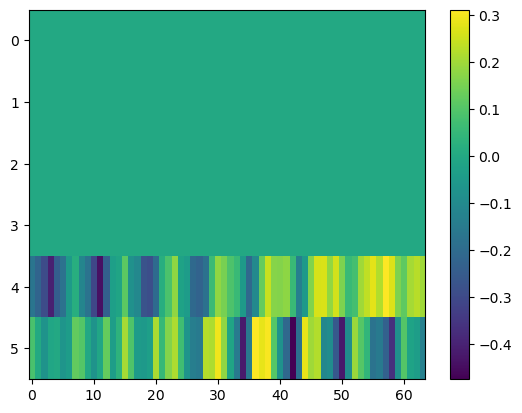

In [3]:
collection_name = "emg_olympics"
subject_name = "alba"
task_name = "center_hold"

c = collection.Collection(collection_name)
s = c.subjects[subject_name]
print(s.decoder.shape)
plt.figure()
plt.imshow(s.decoder, aspect='auto')
plt.colorbar()

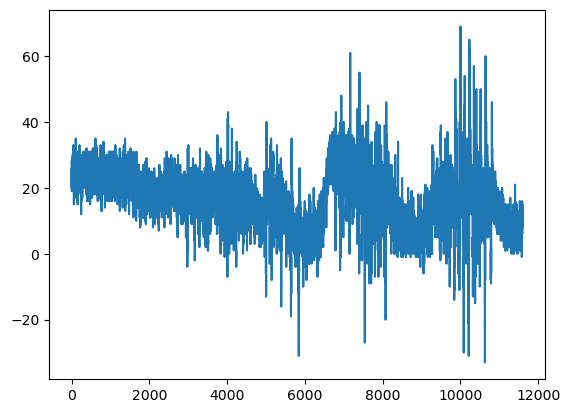

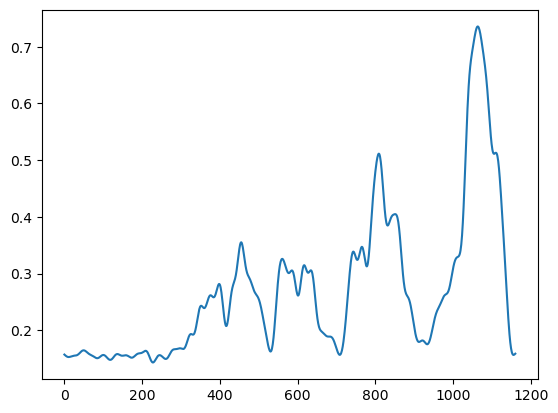

In [4]:
session_num = 1
trial_num = 0
trial = s.tasks["center_hold"].sorted_sessions()[15].sorted_trials()[trial_num]
emg = trial.get_raw_emg()
filtered_emg = trial.get_filtered_emg()
plt.figure()
plt.plot(emg[:,1])
plt.figure()
plt.plot(filtered_emg[:,1])
plt.show()

Cool, we can load emg signals and subject decoders to produce behavioral trajectories.

The behavioral trajectories unfold within the _controlled subspace_ of the EMG activity, which have an effect on the task variable (the position of the cursor on the screen).
The null space of the projection of the EMG into the behavior space defines the _uncontrolled subspace_: muscle activations which have no effect on cursor position.

We want to compute these two subspaces, and then compare the variance within each to understand whether subjects are more or less variable in their task-relevant or task-irrelevant dimensions. Our hypothesis, in concordance with the literature, is that subjects will be less variable in controlled dimensions.

[Here's](https://math.stackexchange.com/questions/1318637/projection-of-a-vector-onto-the-null-space-of-a-matrix) a link to a discussion about computing the null space projection.

[Here's](https://math.stackexchange.com/a/4683344) an even better link relating an orthonormal basis for the null space to the "projector"

D @ e = 0

projector matrix = D.T @ (D @ D.T) @ D @ e 

the "projector" matrix which projects onto the image of A^T because P^2 = P and PA^T = A^T

Our decoders will be [full row rank](https://www.cds.caltech.edu/~murray/amwiki/index.php/FAQ:_What_does_it_mean_for_a_non-square_matrix_to_be_full_rank%3F#:~:text=A%20matrix%20is%20full%20row,and%20columns%20are%20linearly%20independent.), since they have more columns than rows, meaning their columns are linearly dependent (enabling redundancy in the mapping). 



In [5]:
# def compute_task_null_space_projections(sample: np.array, mapping: np.array):
#     sample=sample.T
#     projector = mapping.T@np.linalg.inv(mapping@mapping.T)@mapping
#     task = projector@sample
#     null = (np.eye(sample.shape[0]) - projector)@sample
#     return task.T, null.T

# def compute_task_space_projection(mapping):
#     p = mapping.T@np.linalg.inv(mapping@mapping.T)@mapping
#     print(p.shape)
#     return p

# def compute_null_space_projection(mapping):
#     projector = mapping.T@np.linalg.inv(mapping@mapping.T)@mapping
#     p = np.eye(mapping.shape[1]) - projector
#     print(p.shape)
#     return p

# these are both SVD-based 
# together, they form an orthonormal basis for the decoder
# def compute_null_ortho_subspace(mapping):
#     return scipy.linalg.null_space(mapping).T

# def compute_task_ortho_subspace(mapping):
#     return scipy.linalg.orth(mapping.T).T

def compute_emg_covariance(signal):
    return np.cov(signal.T)

def compute_subspaces(decoder):
    assert len(decoder.shape) == 2
    assert decoder.shape[0] < decoder.shape[1]
    _, _, Vt = np.linalg.svd(decoder, full_matrices=True, compute_uv=True)
    # the short side of the decoder, 2x64 in our task
    decoder_dim = decoder.shape[0]
    # task space and null space transposed
    return Vt.T[:,:decoder_dim].T, Vt.T[:,decoder_dim:].T

def mean_quadratic_form(transformation, subspace_vectors):
    # for each row in x, compute x.T@A@x
    # take the average over these quadratics
    mean = 0
    dim_subspace = subspace_vectors.shape[0]
    for u in subspace_vectors:
        u = u.reshape(-1,1)
        # flatten the quadratic into a number
        mean += (u.T @ transformation @ u).ravel()
    # flatten mean into a number
    return (mean / dim_subspace).ravel()

A = np.eye(64)
X = np.eye(64)[-10:,:]
assert 1. == mean_quadratic_form(A, X)

## test variance ratio with fake data

In [6]:
# make covariance, sample one fake trial
N = 64
cov = np.eye(N)*2
cov[-2,-2] = 100
cov[-1,-1] = 100
T = 1000
one_trial = np.random.multivariate_normal(np.arange(N), cov, size=T)
print(one_trial.shape)

# make a decoder that pulls out only high-var channels from the trial
fake_decoder = np.eye(N)[-2:,:]
print(fake_decoder.shape)
task, null = compute_subspaces(fake_decoder)
cov_computed = compute_emg_covariance(one_trial)
# compute task and null space projections based on the decoder
task_mean = mean_quadratic_form(cov_computed, task)
null_mean = mean_quadratic_form(cov_computed, null)

# this should be 50: 
# the task space is the avg var of the high-var channels (var=100)
# the null space is the avg var of the low-var channels (var=2) 
# 100 / 2 = 100
task_mean / null_mean

(1000, 64)
(2, 64)


array([50.50524143])

## look at hold times

(array([19733.,  1136.,  2122.,   698.,   389.,   251.,   158.,   132.,
          102.,    73.]),
 array([153.33334 , 208.000006, 262.666672, 317.333338, 372.000004,
        426.66667 , 481.333336, 536.000002, 590.666668, 645.333334,
        700.      ]),
 <BarContainer object of 10 artists>)

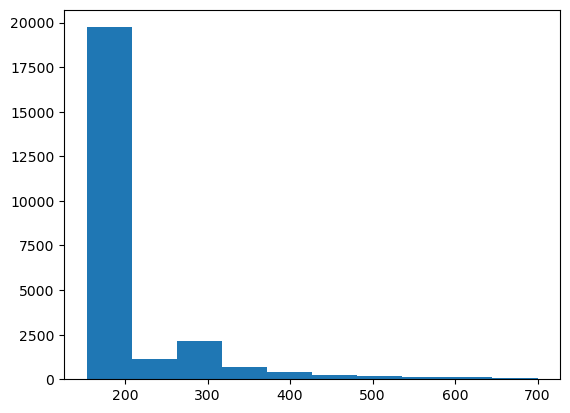

In [7]:
SAMPLE_RATE = 200
hold_times = []
hold_time_with_trials = []
for s in c.subjects.values():
    for sesh in s.tasks[task_name].sorted_sessions():
        for trial in sesh.sorted_trials():
            if trial.outcome in ["Hit", "Miss"]:
                hold_times.append(trial.hold_time*SAMPLE_RATE)
                hold_time_with_trials.append((trial.hold_time*SAMPLE_RATE, trial))

plt.hist(hold_times)

[(700.0, <analysis.collection.Trial object at 0x11fdf3b90>), (700.0, <analysis.collection.Trial object at 0x11fb93ed0>), (700.0, <analysis.collection.Trial object at 0x11ed7d310>), (700.0, <analysis.collection.Trial object at 0x11e7ecf10>), (700.0, <analysis.collection.Trial object at 0x11e70fe10>), (696.6666, <analysis.collection.Trial object at 0x11fe32dd0>), (693.3334, <analysis.collection.Trial object at 0x12f00f950>), (693.3334, <analysis.collection.Trial object at 0x11fda3710>), (693.3334, <analysis.collection.Trial object at 0x11e82ad50>), (693.3334, <analysis.collection.Trial object at 0x11e072190>)]
(955, 3)
(1525, 3)
(884, 3)
(1088, 3)
(1704, 3)
(706, 3)
(711, 3)
(1158, 3)
(451, 3)
(1153, 3)


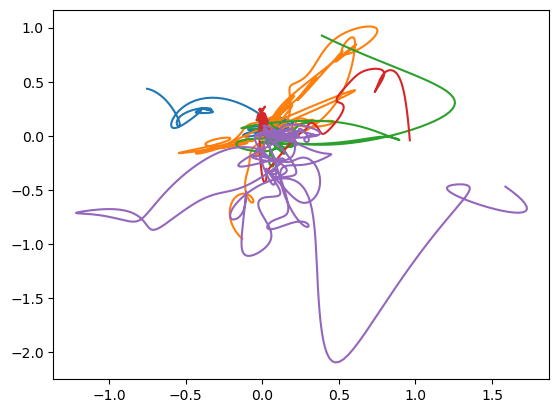

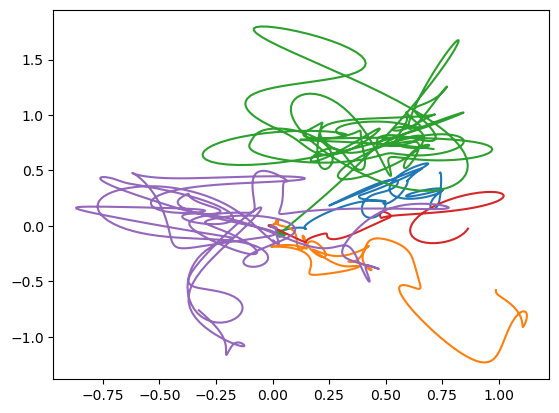

In [8]:
sorted_hold_times = sorted(hold_time_with_trials, key=lambda x: x[0])[::-1]

print(sorted_hold_times[:10])

# longest hold times
for i in range(5):
    traj = sorted_hold_times[i][1].get_trajectory()
    print(traj.shape)
    plt.plot(traj[:,-2],traj[:,-1])

# shortest hold times
plt.figure()
sorted_hold_times = sorted_hold_times[::-1]
for i in range(5):
    traj = sorted_hold_times[i][1].get_trajectory()
    print(traj.shape)
    plt.plot(traj[:,-2],traj[:,-1])


## taking the residual of the "ideal" movement

In [9]:
# for each time step
# i take the next step in some direction
# what is the difference between taking that next step
# and taking the same length step in the direction towards the target


trials = []
subject_idx = 10
subject = list(c.subjects.values())[subject_idx]
for sesh in subject.tasks[task_name].sorted_sessions():
    for trial in sesh.sorted_trials():
        if trial.outcome in ["Hit", "Miss"]:
            trials.append(trial)

residuals = []
for trial in trials:
    target = np.array(trial.target_coords)
    traj = trial.get_trajectory()
    i = 0
    if trial.outcome == "Hit":
        for first_coord, next_coord in zip(traj[400:-1,-2:],traj[401:,-2:]):
            step = next_coord - first_coord
            step_length = np.linalg.norm(step)
            scaled_target = step_length*target
            old_residual = residual
            residual =  -step + scaled_target
            residuals.append(residual)
            # if i == 501:
            #     plt.arrow(first_coord[0],first_coord[1],step[0], step[1], color="k", label="Step", width=0.00001)
            #     plt.arrow(first_coord[0],first_coord[1],scaled_target[0], scaled_target[1], color="b", label="Scaled Target", width=0.00001)
            #     plt.arrow(next_coord[0], next_coord[1],residual[0],residual[1], color="r", width=0.00001, label="Residual")
            # else:
            plt.arrow(next_coord[0], next_coord[1],residual[0],residual[1], color="r", width=0.00001)
            plt.arrow(first_coord[0],first_coord[1],step[0], step[1], color="k", width=0.00001)
            plt.arrow(first_coord[0],first_coord[1],scaled_target[0], scaled_target[1], color="b", width=0.00001)
            plt.plot(old_residual, residual, 'o', color="tab:purple")
            i += 1
        plt.legend()    
        plt.plot(target[0],target[1],"ko",markersize=80)
        break
plt.figure()
residuals = np.array(residuals)
plt.plot(residuals[:,0])
plt.plot(residuals[:,1])


NameError: name 'residual' is not defined

This doesn't make sense, we're already in task space

We really want to subtract from the EMG signal the ideal movement

What is the ideal EMG activity? We can assume it's the minimum-norm pseudoinverse of the decoder

D * e = t
e_ideal = D_inverse * t

Can we do this for each residual? 

If the residuals are larger, this will mean higher variance.
A larger residual means moving higher in the wrong direction.
The only issue with a scaled residual is if we're not moving at all, the residual is low.
But we're looking at the VARIANCE of the residual-- so higher variance is non-task-specific/correct/ideal movement... as opposed to just task movement

## what happens when we pseudoinverse then decode again?

A: we get back what we started with! 

## what happens to the emg? do we recover it?

A: No! This could be interesting? The solution produced by subjects doesn't agree with the Moore-Penros, minimum-norm solution?

So we of course can't recover the EMG from the inverse, that's the whole point.
But maybe we can use this-- can we define our residual as what people are doing beyond an optimal solution, defined by, perhaps, least-squares 

## what is the ideal solution? can we come up with one?

if we take the hold time, and the movement time, and we say okay, the optimal trajectory is a direct-line movement to the target at a force that would get you to the target in the same time as the actual trial.
it's a little like the residual idea 

## todo

- get the positive regression working
- use that to produce an ideal trajectory?
- 

In [198]:
def vectorize_emg(emg, N, T):
    assert emg.shape == (N,T), f"Invalid emg shape {emg.shape} instead of {(N,T)}"
    return emg.flatten(order="F").reshape(N*T,1) 

def vectorize_output(output, D, T):
    assert output.shape == (D,T), f"Invalid output shape {output.shape} instead of {(D,T)}"
    return output.flatten(order="F").reshape(D*T,1)

def make_block_decoder(decoder, D, N, T):
    # copy out the decoder for each time point
    assert decoder.shape == (D,N), f"Invalid decoder shape {decoder.shape} instead of {(D,N)}"
    blocklist = []
    zeros = np.zeros(shape=fake_decoder.shape)
    for i in range(T):
        row = []
        for j in range(T):
            row.append(zeros)
        row[i] = decoder
        blocklist.append(row)
    A = np.block(blocklist)
    assert A.shape == (D*T, N*T)
    return A

def nnls(decoder, output, D, N, T):
    A = make_block_decoder(decoder, D, N, T)
    b = vectorize_output(output, D, T)
    assert b.shape[1] == 1
    b = b.reshape(-1)
    input, residual = scipy.optimize.nnls(A, b)
    return input, residual

def unvectorize_emg(decoder, emg_vec, T):
    # T: the number of time points / samples
    # vec: emg or output vector
    return emg_vec.reshape(T,decoder.shape[1]).T

def unvectorize_output(decoder, output_vec, T):
    # T: the number of time points / samples
    # vec: emg or output vector
    return output_vec.reshape(T,decoder.shape[0]).T


D = 2
N = 64
T = 5
fake_decoder = np.vstack([np.ones(N)*0.1, np.ones(N)*0.1])
fake_emg_data = np.ones(shape=(N,T))*0.1 # np.vstack([i*np.arange(1,T+1) for i in range(1,N+1)])
# compute the actual output b based on the inputs A,x
# Ax = b
fake_traj_data = fake_decoder @ fake_emg_data
# fake_traj_data = np.vstack([i*np.arange(1,T+1) for i in range(1,D+1)])

fake_emg_vec =  fake_emg_data.flatten(order="F").reshape(N*T,1)

nnls_input, residual = nnls(fake_decoder, fake_traj_data, D, N, T)
nnls_input = unvectorize_emg(fake_decoder, nnls_input, T)
# print(nnls_input)
# print(fake_emg_data)

print(fake_decoder @ nnls_input)
print(fake_traj_data)

print(nnls_input)
print(fake_emg_data)

[[0.64 0.64 0.64 0.64 0.64]
 [0.64 0.64 0.64 0.64 0.64]]
[[0.64 0.64 0.64 0.64 0.64]
 [0.64 0.64 0.64 0.64 0.64]]
[[6.4 6.4 6.4 6.4 6.4]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.

In [200]:
decoder = subject.decoder[-2:,:]
trial = trials[4]
traj = trial.get_trajectory()[:,-2:].T
emg = trial.get_filtered_emg().T
print(decoder.shape, traj.shape, emg.shape)
T = np.min(traj.shape[1], emg.shape[1])
traj = traj[:,:T]
emg = emg[:,:T]
D = decoder.shape[0]
N = emg.shape[0]
T = emg.shape[1]
nnls(decoder, traj, )

(2, 64) (2, 1156) (64, 1158)


(2, 64) (64, 2)
(64, 1158) (2, 1156) (2, 1156)


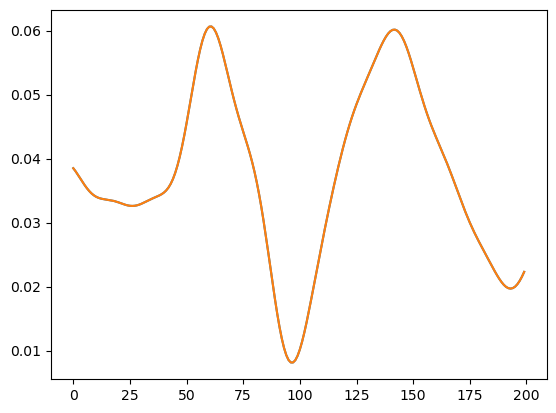

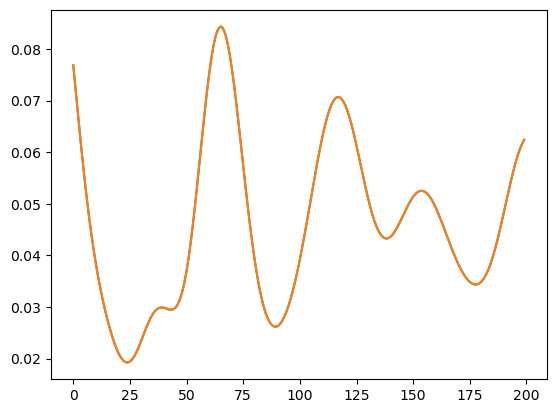

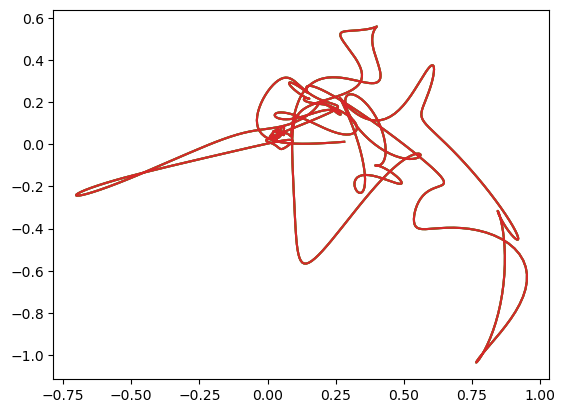

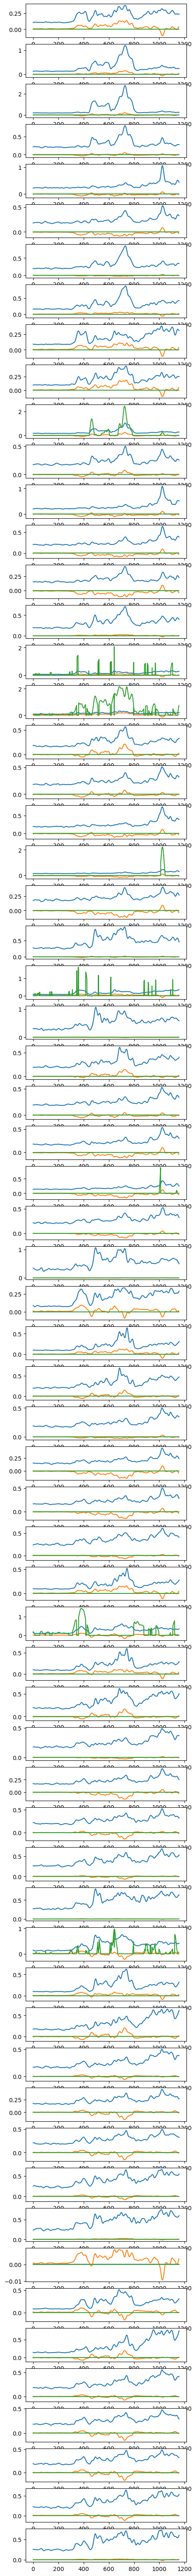

In [128]:
decoder = subject.decoder[-2:,:]
# norm-min Moore-Penrose, linear least squares
inv_decoder = np.linalg.pinv(decoder)
print(decoder.shape, inv_decoder.shape)

trial = trials[4]

femg = trial.get_filtered_emg().T
traj = trial.get_trajectory()[:,-2:].T

# nonlinear leat squares
# solves argmin_x ||Ax - b||_2 subject to x>0 
# this is Decoder @ emg - trajectory for emg subject to emg > 0
# f(A, b)
nnls_emg = np.empty(shape=(decoder.shape[1], traj.shape[1]))
for i, t in enumerate(traj.T):
    # 2x64 @ 64x1 = 2x1
    res = scipy.optimize.nnls(decoder, t)
    nnls_emg[:,i] = res[0]

repro_traj = decoder @ femg
trim = repro_traj.shape[1] - traj.shape[1]
repro_traj = repro_traj[:,trim:]

print(femg.shape, traj.shape, repro_traj.shape)

hold = traj.shape[1] // 2
offset_x = traj[0,hold] - repro_traj[0,hold]
offset_y = traj[1,hold] - repro_traj[1,hold]

plt.figure()
plt.plot(repro_traj[-2,:200] + offset_x)
plt.plot(traj[-2,:200])
plt.figure()
plt.plot(repro_traj[-1,:200] + offset_y)
plt.plot(traj[-1,:200])

plt.figure()
plt.plot(repro_traj[-2,:] + offset_x, repro_traj[-1,:] + offset_y)
plt.plot(traj[-2,:], traj[-1,:])

inv_emg = inv_decoder @ traj
inv_inv_traj = decoder @ inv_emg
plt.plot(inv_inv_traj[-2,:], inv_inv_traj[-1,:])

nnls_traj = decoder @ nnls_emg
plt.plot(nnls_traj[0,:],nnls_traj[1,:])

fig, axes = plt.subplots(64,1,figsize=(5,80))
for i, ax in enumerate(axes): 
    ax.plot(femg[i])
    ax.plot(inv_emg[i])
    ax.plot(nnls_emg[i])

## ideal trajectory

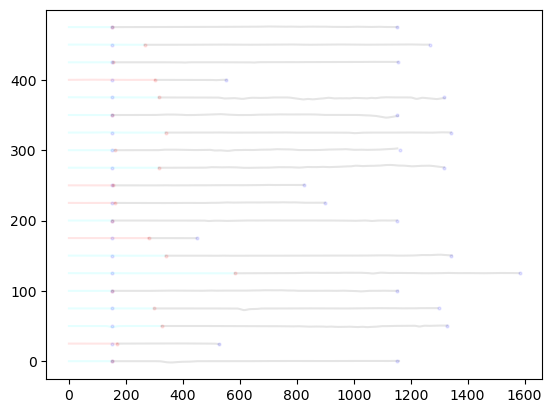

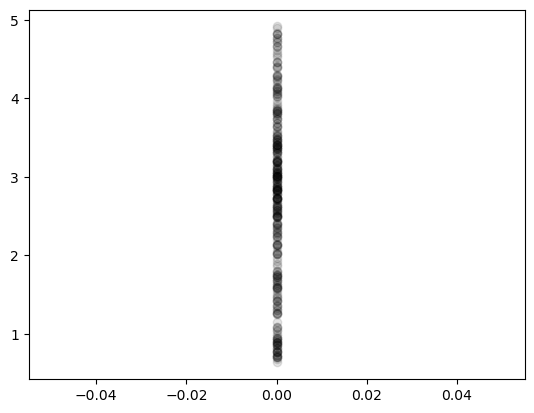

In [75]:
# hold time -- once hold period has been hit
# 
# reach time -- 

i = 0
for trial in trials[:20]:
    traj = trial.get_trajectory()[:, -2:]
    # print(trial.outcome, trial.hold_time, trial.reach_time)
    hold_time = int(200*trial.hold_time)
    plt.plot(int(200*.76666666667), i, "bo", alpha=0.1, markersize=2)
    if trial.outcome == "Hit":
        plt.plot(traj[:hold_time,0]+i,"r",alpha=0.1)
        reach_time = int(200*trial.reach_time)
        plt.plot(reach_time + hold_time, i, "bo", alpha=0.1, markersize=2)
    else:
        plt.plot(traj[:hold_time,0]+i,"cyan",alpha=0.1)
        plt.plot(5*200 + hold_time, i, "bo", alpha=0.1, markersize=2)
    plt.plot(range(hold_time,traj.shape[0]), traj[hold_time:,0] + i ,"k",alpha=0.1)
    plt.plot(hold_time, i, "ro", alpha=0.1, markersize=2)
    i += 25

plt.figure()
for trial in trials:
    if trial.outcome == "Hit":
        plt.plot(0,trial.reach_time,"ko", alpha=0.1)

525 529
449 449
898 900
825 827
552 554
915 915
1032 1034
482 484
695 690
888 891
1085 1080
798 803
408 410
1218 1219
492 493
901 897
1128 1131


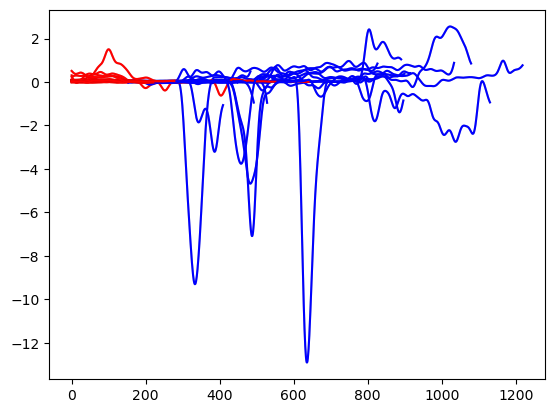

In [127]:
# take the hold time
# take the movement time 
# target vector
# divide the target by the number movement steps to get the trajectory (plus a little cushion)
# this is an ideal trajectory, what do we do with that? 

target = trial.target_coords 
# 750 hold
# 5000 reach
# 2000 ITI
i = 0
for trial in trials[:50]:
    if trial.outcome == "Hit":
        hold_time = int(200*trial.hold_time)
        movement_time = int(200*trial.reach_time)
        traj = trial.get_trajectory()[:,-2:]
        plt.plot(traj[:,0]+i, "k",alpha=.2)
        plt.plot(traj[:hold_time,0]+i,"r",alpha=1)
        total_time = hold_time + movement_time - 1
        print(total_time, traj.shape[0])
        plt.plot(range(hold_time, traj.shape[0]), traj[hold_time:,0]+i,"b",alpha=1)


## compute the mean null and task space variance projections

In [10]:
# for each trial
c = collection.Collection("emg_olympics")
null_trial_means_over_subjects = {}
task_trial_means_over_subjects = {}
null_sesh_means_over_subjects = {}
task_sesh_means_over_subjects = {}
ratios_over_trials_over_subjects = {}
for s in c.subjects.values():
    decoder = s.decoder[-2:, :]
    null_trial_means_over_subjects[s.name] = []
    task_trial_means_over_subjects[s.name] = []
    null_sesh_means_over_subjects[s.name] = []
    task_sesh_means_over_subjects[s.name] = []
    for sesh in s.tasks[task_name].sorted_sessions():
        sesh_null_means = []
        sesh_task_means = []
        for trial in sesh.sorted_trials():
            if trial.outcome in ["Hit", "Miss"]:
                # get trajectory and cut off the hold period
                trajectory = trial.get_filtered_emg()[int(trial.hold_time*SAMPLE_RATE):,:]
                # compute the electrode covariance of the filtered emg for this trial
                covariance = compute_emg_covariance(trajectory)

                # compute task and null space basis using svd
                task_space, null_space = compute_subspaces(decoder)

                # compute mean of null space projections, add to list
                trial_null_mean = mean_quadratic_form(covariance, null_space)
                null_trial_means_over_subjects[s.name].append(trial_null_mean)

                # same for the task space
                trial_task_mean = mean_quadratic_form(covariance, task_space)
                task_trial_means_over_subjects[s.name].append(trial_task_mean)

                # add trial to sesh list
                sesh_null_means.append(trial_null_mean)
                sesh_task_means.append(trial_task_mean)
        # add sesh list to master sesh list
        null_sesh_means_over_subjects[s.name].append(sesh_null_means)
        task_sesh_means_over_subjects[s.name].append(sesh_task_means)
    ratios_over_trials_over_subjects[s.name] = np.divide(task_trial_means_over_subjects[s.name], null_trial_means_over_subjects[s.name])

## task and null variance 

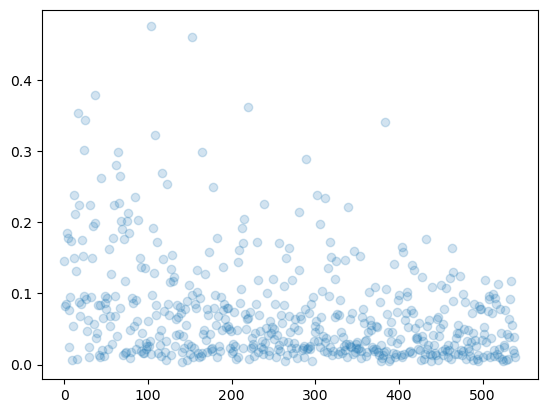

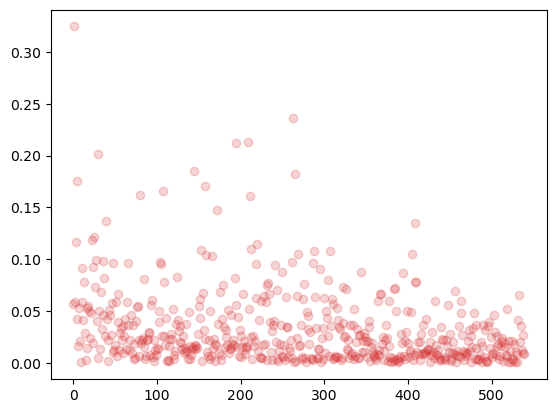

In [21]:
for s in list(c.subjects.values())[1:2]:
    plt.plot(task_trial_means_over_subjects[s.name], "o", c="tab:blue", alpha=0.2)

plt.figure()
for s in list(c.subjects.values())[1:2]:
    plt.plot(null_trial_means_over_subjects[s.name], "o", c="tab:red", alpha=0.2)


## hits vs. average subspace variance ratio (task/null)

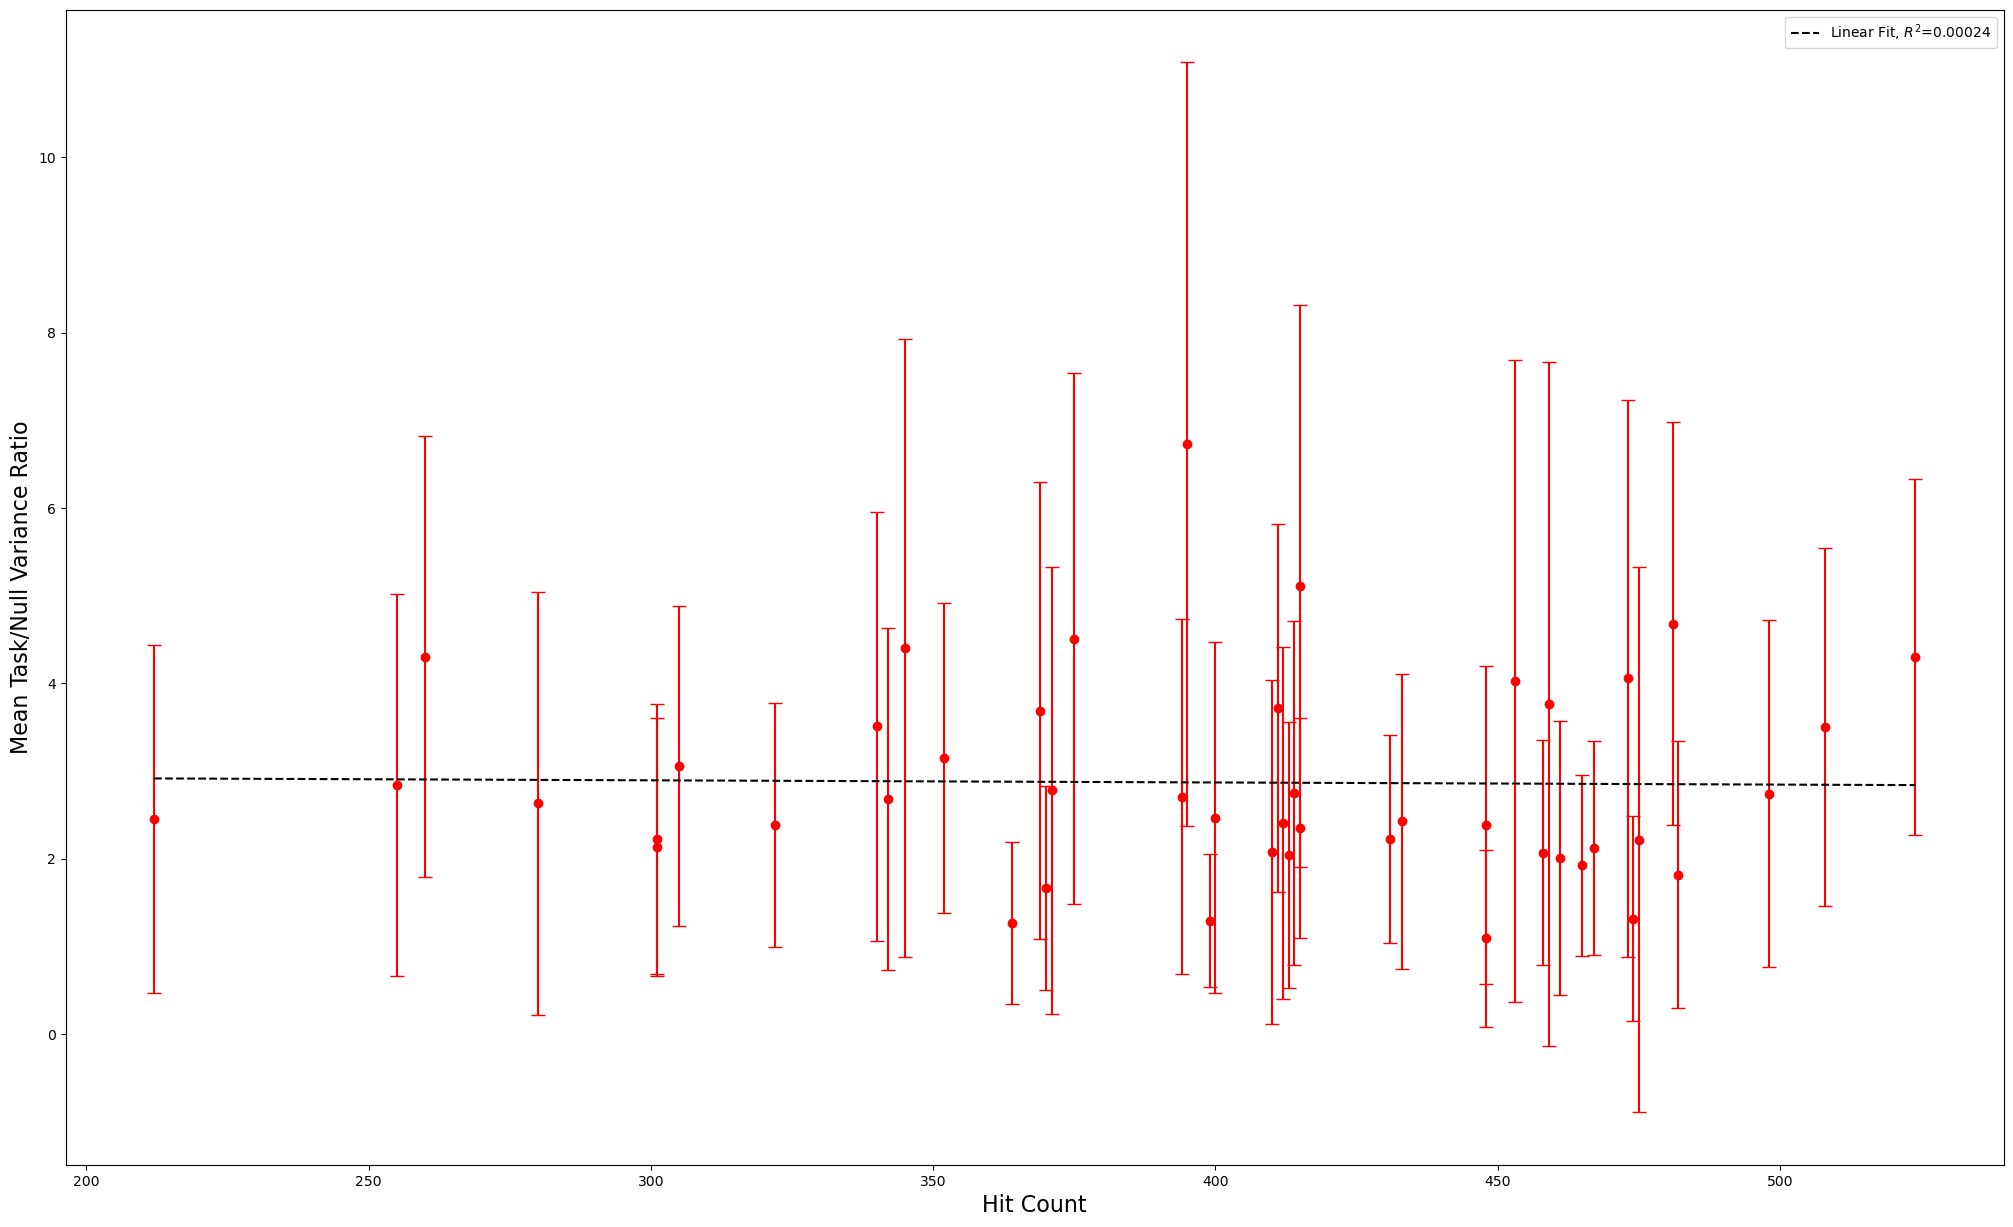

In [11]:
fig, ax = plt.subplots(1,1,figsize=(25,15))

hit_sum_list = []
means = []
for s in c.alphabetically_sorted_subjects():
    hit_sum = sum([outcome["hits"] for outcome in [session.outcome_counts for session in s.tasks["center_hold"].sorted_sessions()]])
    ratios = np.divide(task_trial_means_over_subjects[s.name], null_trial_means_over_subjects[s.name])
    ax.errorbar(hit_sum, np.mean(ratios),yerr=np.std(ratios), capsize=5, c="r", marker="o")
    hit_sum_list.append(hit_sum)
    means.append(np.mean(ratios))

def linear(x, m, b):
    return m*x + b

x = np.linspace(np.min(hit_sum_list), np.max(hit_sum_list), len(means))
result = scipy.stats.linregress(hit_sum_list, means)

ax.plot(x, result.intercept + result.slope*x,"k--", label=f"Linear Fit, $R^2$={np.round(result.rvalue**2, 5)}")
# ax.plot(hit_sum_list, means, "ko", alpha=0.5)
ax.set_xlabel("Hit Count")
ax.set_ylabel("Mean Task/Null Variance Ratio")
ax.legend()

In [12]:
fig.savefig(image_path / "analysis/ratio_vs_hits.pdf", dpi=300, format="pdf")

No correlation between subject grand mean variance ratio and total hits-- implies that mean variance ratio isn't a proxy for learning?

Ideas
- Difference between mean variance ratios for hit trials and miss/no-hold trials? expect Hits to be lower variance ratio
- Mean variance ratios and decoder correlations? 
- Path length vs. task space variance -- sanity check, should correlate as higher path lengths would be more variable
- does time that theyre holding make a difference? -- hwe we expect that it doesnt, purposefully not high-variance
- we're seeing that the task space variability is ~2-3x of the null space. Could this be due to certain EMG channels being very low variance?

Results
- we're confident in our task and null space projections-- we think there's something here to say about manifolds during learning!
- cutting off the hold time doesn't make appreciable difference to the variance ratio results
- path length appears to correlates (ish) with task space variance

## subject grand mean of variance ratio

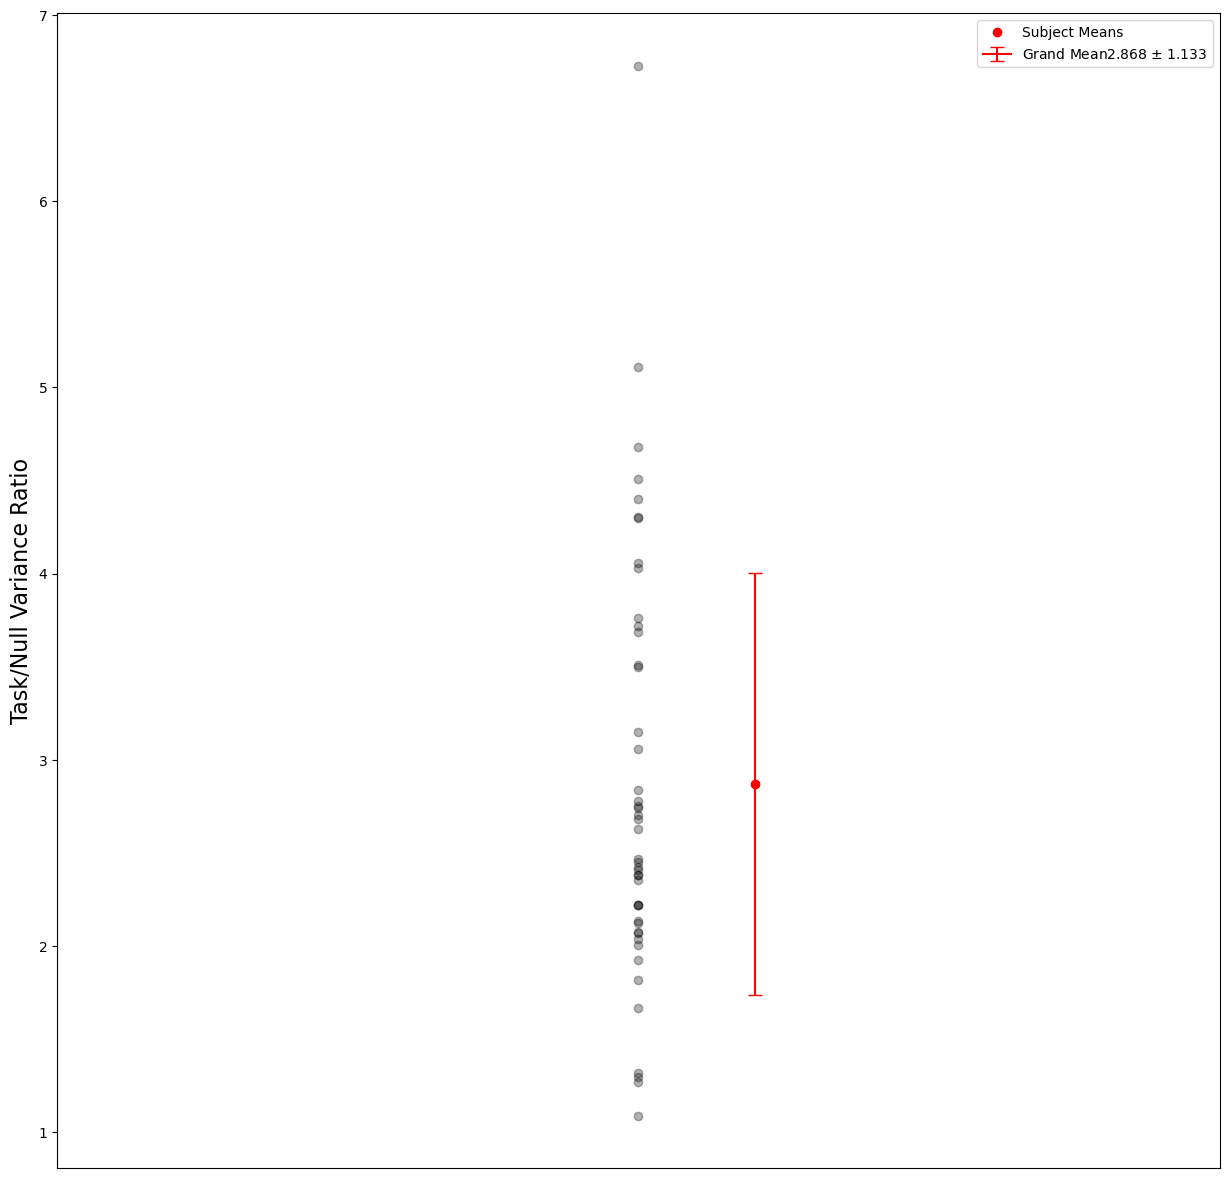

In [13]:
fig, ax = plt.subplots(1,1,figsize=(15,15))
ax.plot(np.zeros(len(means)), means, "ko", alpha=0.3)
ax.plot(.1, np.mean(means), "ro", label="Subject Means")
ax.errorbar(.1, np.mean(means), np.std(means), c="r", capsize=5, label=f"Grand Mean{np.round(np.mean(means),3)} $\pm$ {np.round(np.std(means),3)}")
ax.set_xlim(-.5,.5)
ax.set_ylabel("Task/Null Variance Ratio")
ax.set_xticks([])
ax.legend()

In [14]:
fig.savefig(image_path / "analysis/ratio_grand_mean.pdf", dpi=300, format="pdf")

## visually inspect per-subject trial-level variance ratios

Text(0, 0.5, 'Mean Task / Null Variance Ratio')

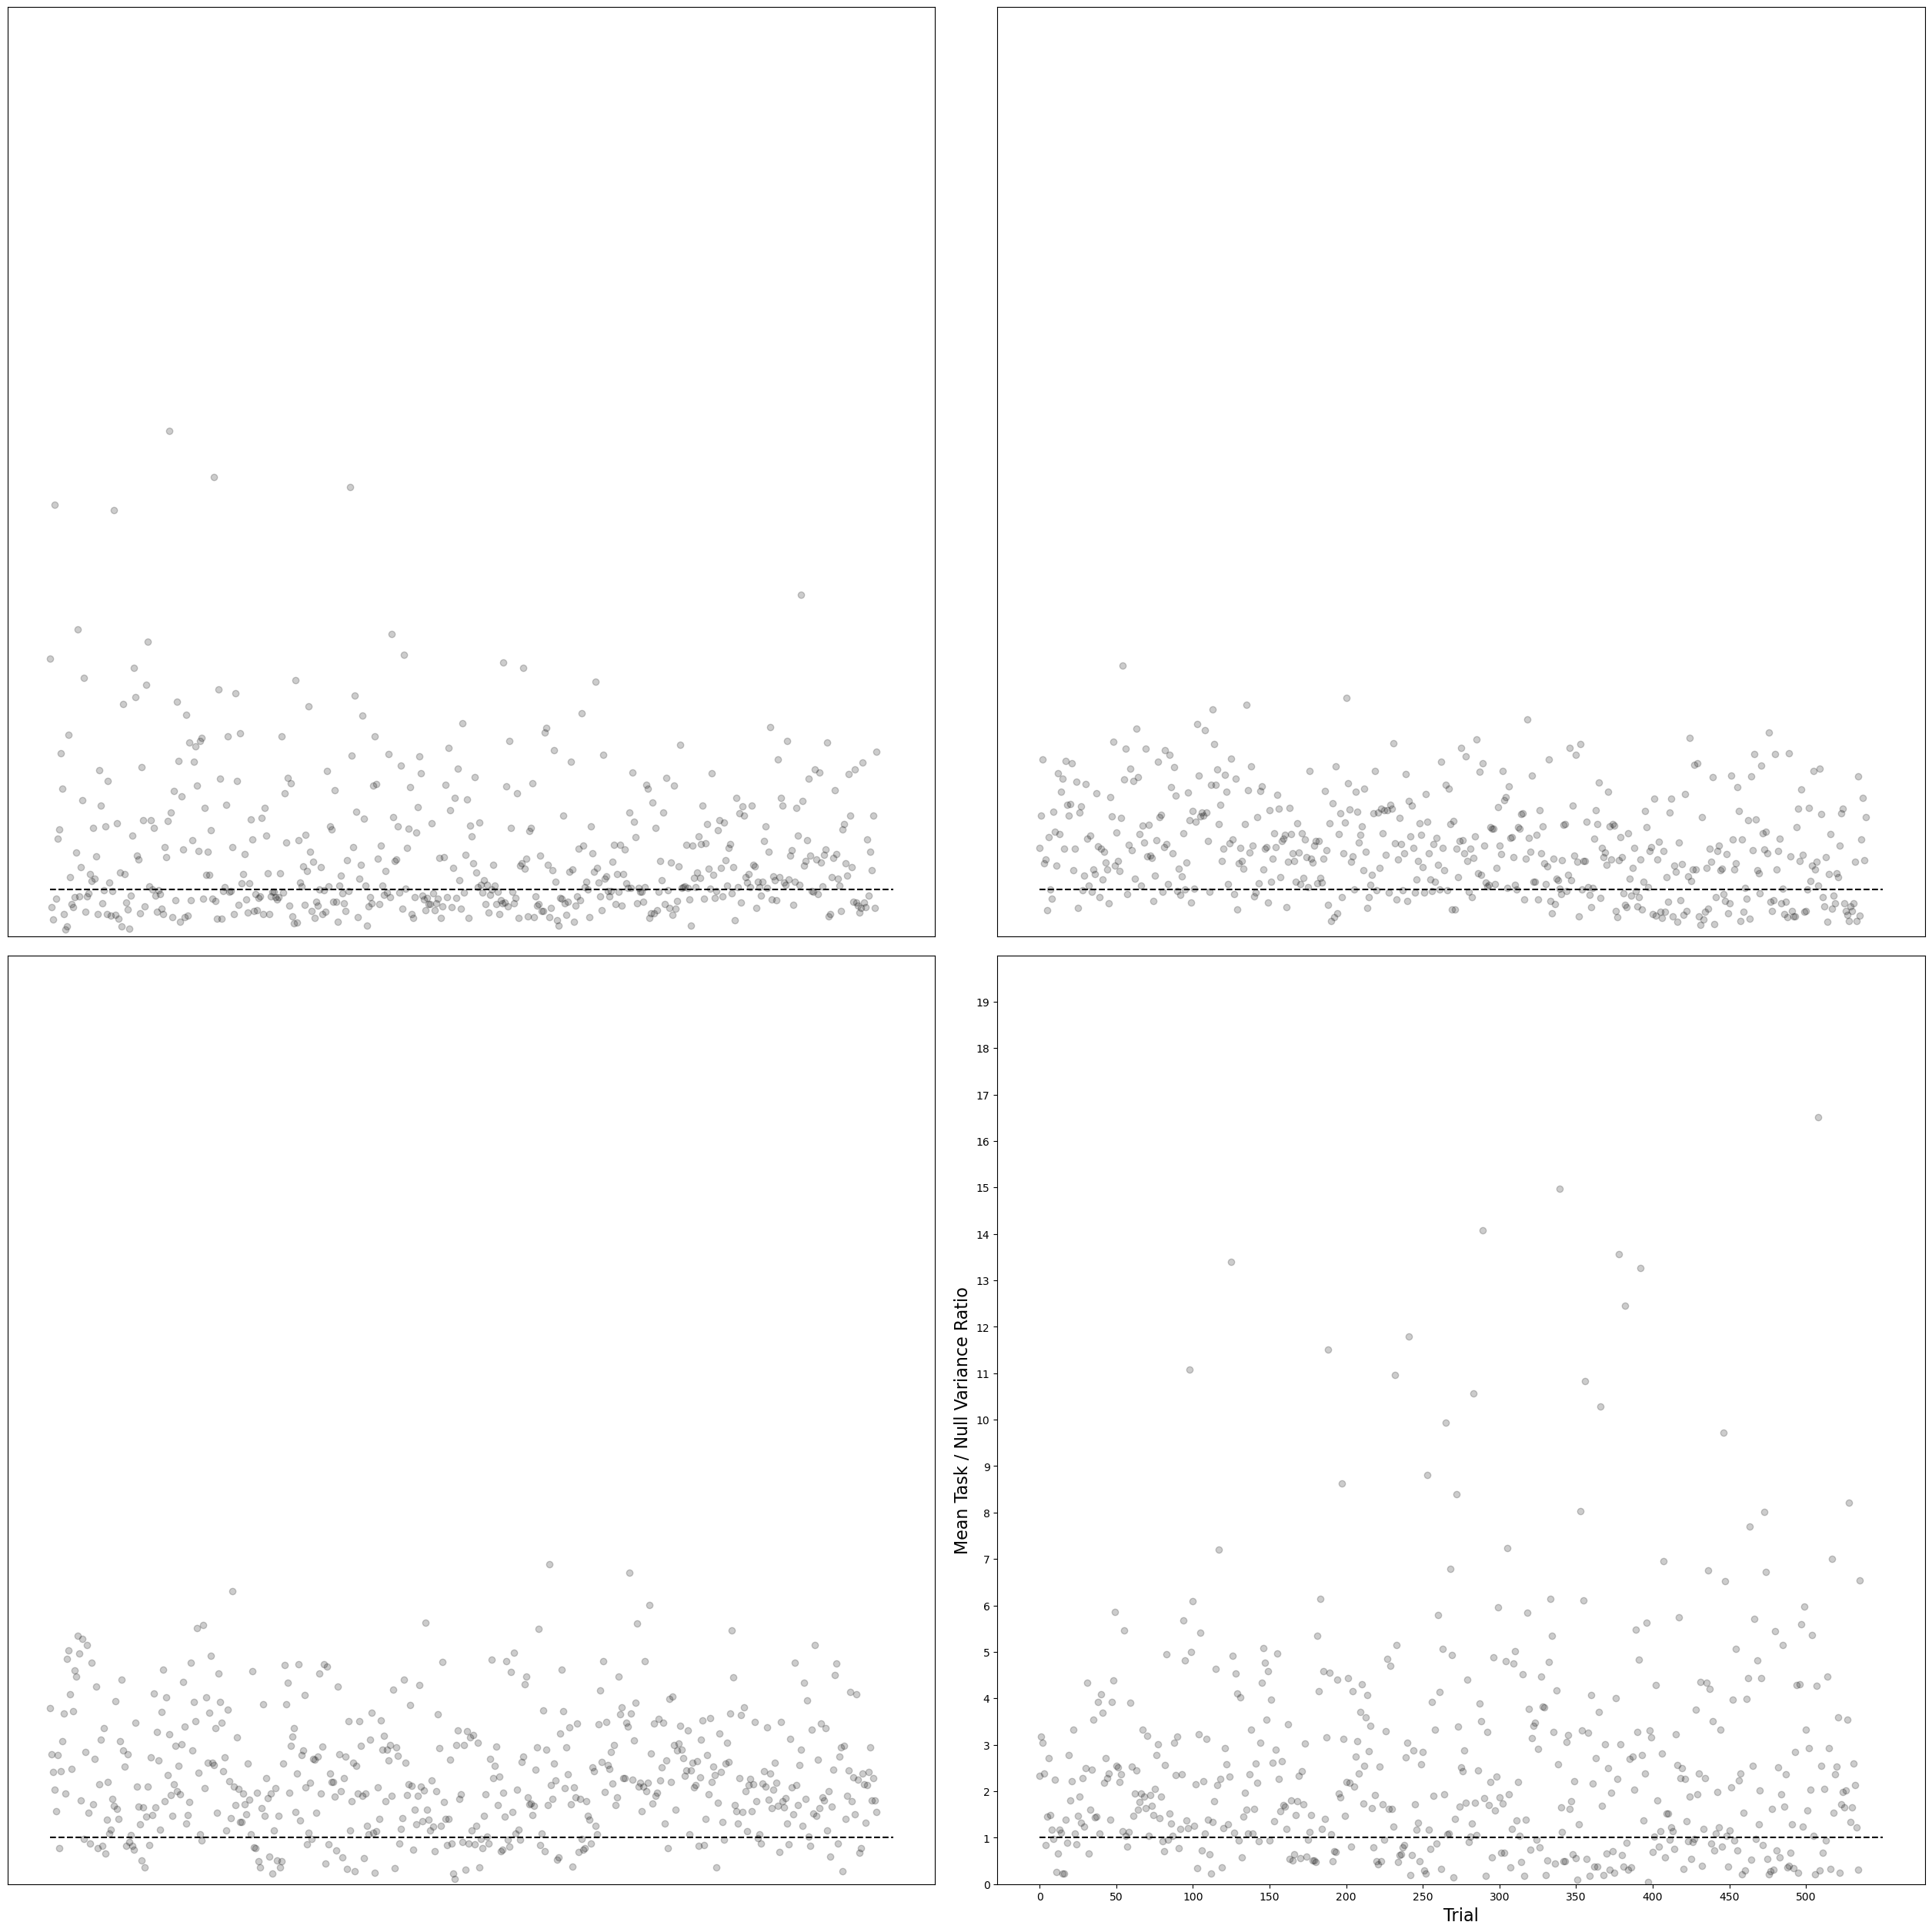

In [15]:
import matplotlib.gridspec as gridspec
fig, axes = plt.subplots(ncols=2, nrows=2, constrained_layout=True, figsize=(25,25))

all_ratios = []
for ax, s in zip(axes.ravel(), c.alphabetically_sorted_subjects()[::15]):
    # print(len(task_trial_means_over_subjects[s.name]), len(null_trial_means_over_subjects[s.name]))
    ratios = np.divide(task_trial_means_over_subjects[s.name], null_trial_means_over_subjects[s.name])
    hit_mask = [trial.outcome for trial in  [trial for sesh in s.tasks[task_name].sorted_sessions()]]
    all_ratios.append(ratios)
    ax.plot(ratios, "ko", alpha=0.2)
    ax.plot([0,550],[1,1],"k--")
    ax.set_ylim(0,20)
    ax.set_yticks([])
    ax.set_xticks([])
ax.set_yticks(range(20))
ax.set_xticks(range(0,550,50))
ax.set_xlabel("Trial")
ax.set_ylabel("Mean Task / Null Variance Ratio")

In [16]:
fig.savefig(image_path / "analysis/ratio_over_trials.pdf", dpi=300, format="pdf")

## does "Hit" and "Miss" path length correlate with task-space variability? (we expect it to!)

In [17]:
# compute path lengths

def path_length(a):
    assert a.shape[0] > a.shape[1], f"array with shape {a.shape} should be transposed."
    assert a.shape[1] == 2, f"array with shape {a.shape} must be two-dimensional"
    return np.sum(np.sqrt(np.sum(np.diff(a, axis=0)**2,axis=1)))

sample_rate = 200 # samples / sec

path_lengths_over_trials = {}
for sub in c.subjects.values():
    path_lengths_over_trials[sub.name] = []
    # for each session
    for session in sorted(list(sub.tasks["center_hold"].sessions.values()),key=lambda s: s.number):
        sorted_trials = sorted(list(session.trials.values()), key=lambda d: d.number)
        for t in sorted_trials:
            # only look at Hit trials
            if t.outcome in ["Hit", "Miss"]:
                traj = t.get_trajectory()
                # path length of movement time / reach time -- basically average velocity
                movement_portion = traj[(int(np.ceil(t.hold_time*sample_rate))):,-2:]
                path_lengths_over_trials[sub.name].append(path_length(movement_portion))

### linear fit / plot

Text(0.5, 0, 'Path Length, Hits and Misses')

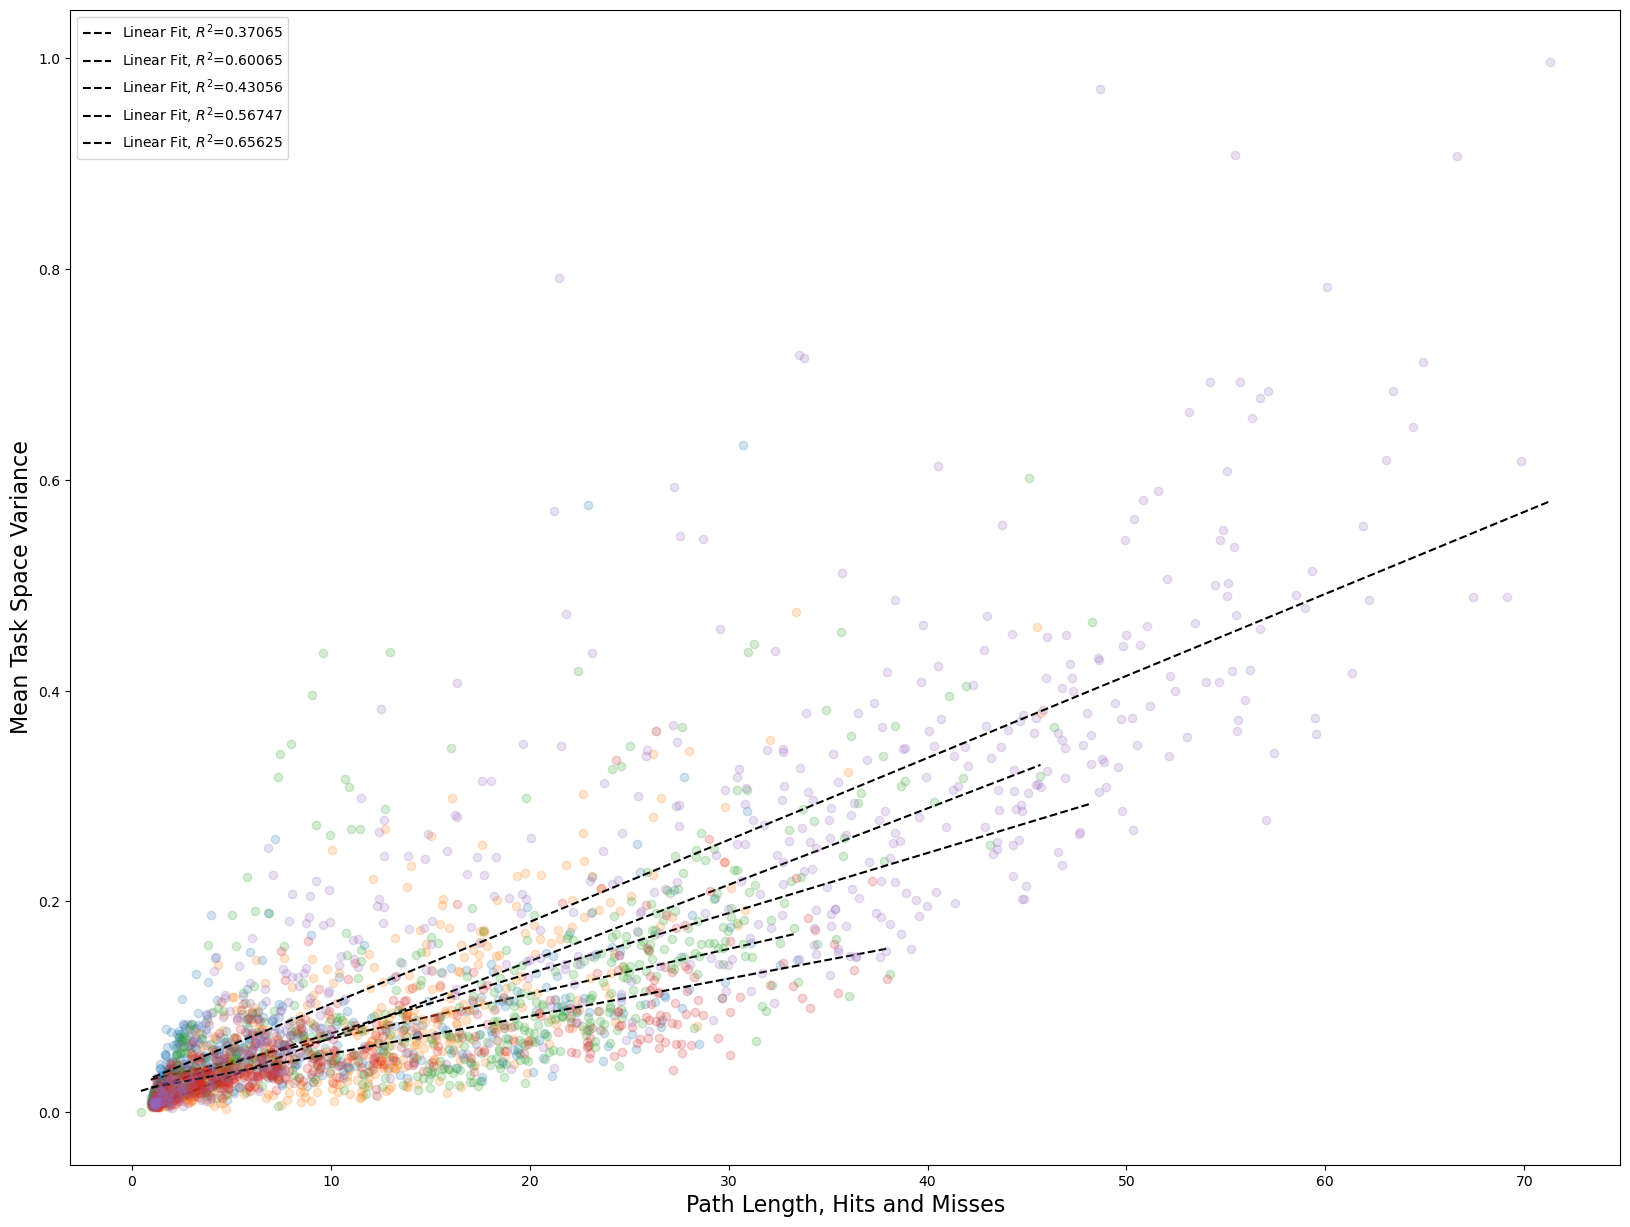

In [18]:
all_ratios = []
fig, ax = plt.subplots(figsize=(20,15))
for s in c.alphabetically_sorted_subjects()[0:5]:
    # print(len(task_trial_means_over_subjects[s.name]), len(null_trial_means_over_subjects[s.name]))
    # ratios = np.divide(, null_trial_means_over_subjects[s.name])
    ax.plot(path_lengths_over_trials[s.name], task_trial_means_over_subjects[s.name], "o", alpha=0.2)
    x = np.linspace(np.min(path_lengths_over_trials[s.name]), np.max(path_lengths_over_trials[s.name]), len(path_lengths_over_trials[s.name]))
    result = scipy.stats.linregress(path_lengths_over_trials[s.name], [x[0] for x in task_trial_means_over_subjects[s.name]])
    ax.plot(x, result.intercept + result.slope*x,"k--", label=f"Linear Fit, $R^2$={np.round(result.rvalue**2, 5)}")
ax.legend()
ax.set_ylabel("Mean Task Space Variance")
ax.set_xlabel("Path Length, Hits and Misses")

In [19]:
fig.savefig(image_path / "analysis/path_length_vs_ratio_linear.pdf", dpi=300, format="pdf")

### log plot / fit

Text(0.5, 0, 'Log Path Length, Hits and Misses')

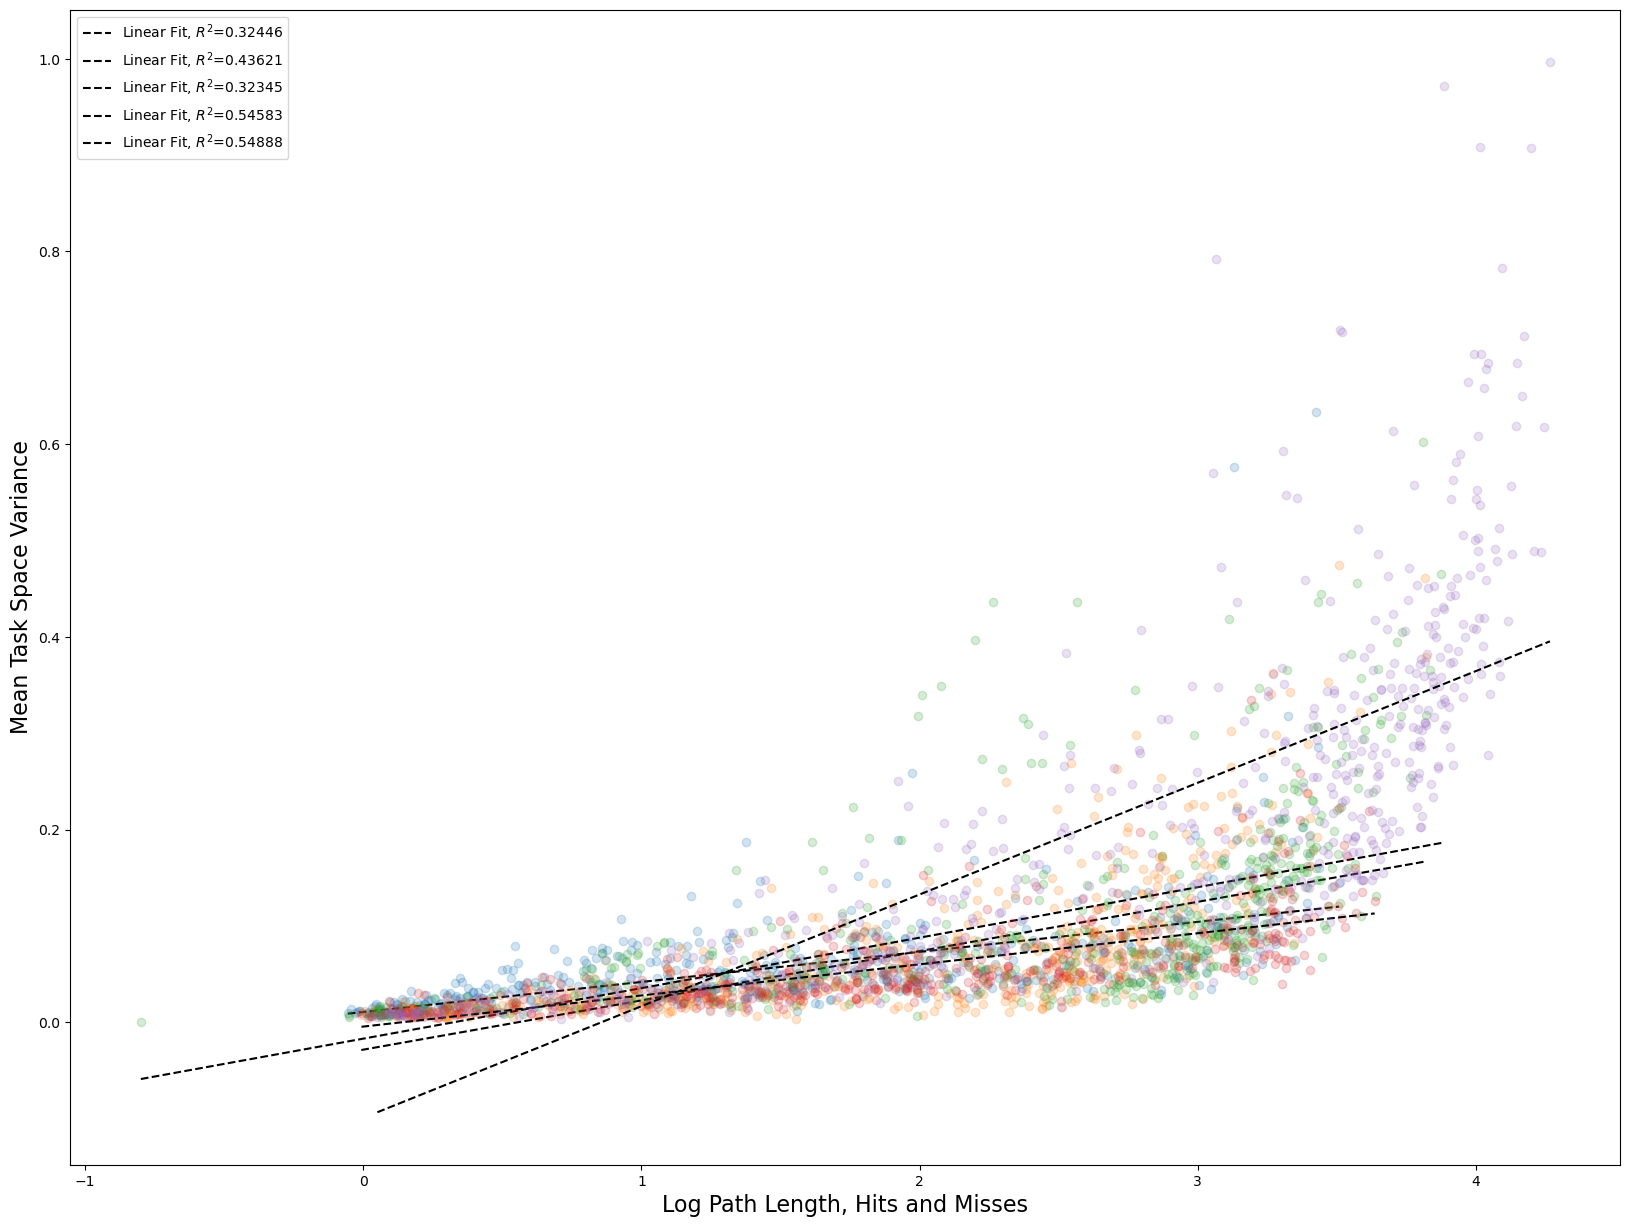

In [20]:
all_ratios = []
fig, ax = plt.subplots(figsize=(20,15))
for s in c.alphabetically_sorted_subjects()[0:5]:
    # print(len(task_trial_means_over_subjects[s.name]), len(null_trial_means_over_subjects[s.name]))
    # ratios = np.divide(, null_trial_means_over_subjects[s.name])
    log_path_length = np.log(path_lengths_over_trials[s.name])
    ax.plot(log_path_length, task_trial_means_over_subjects[s.name], "o", alpha=0.2)
    x = np.linspace(np.min(log_path_length), np.max(log_path_length), len(log_path_length))
    result = scipy.stats.linregress(log_path_length, [x[0] for x in task_trial_means_over_subjects[s.name]])
    ax.plot(x, result.intercept + result.slope*x,"k--", label=f"Linear Fit, $R^2$={np.round(result.rvalue**2, 5)}")
ax.legend()
ax.set_ylabel("Mean Task Space Variance")
ax.set_xlabel("Log Path Length, Hits and Misses")

In [21]:
fig.savefig(image_path / "analysis/path_length_vs_ratio_log.pdf", dpi=300, format="pdf")

Somewhere between linear and log for path length? 

There is some correlation between path length and task space variance, which is a good sanity check for me

## Mean Variance Ratio over Blocks

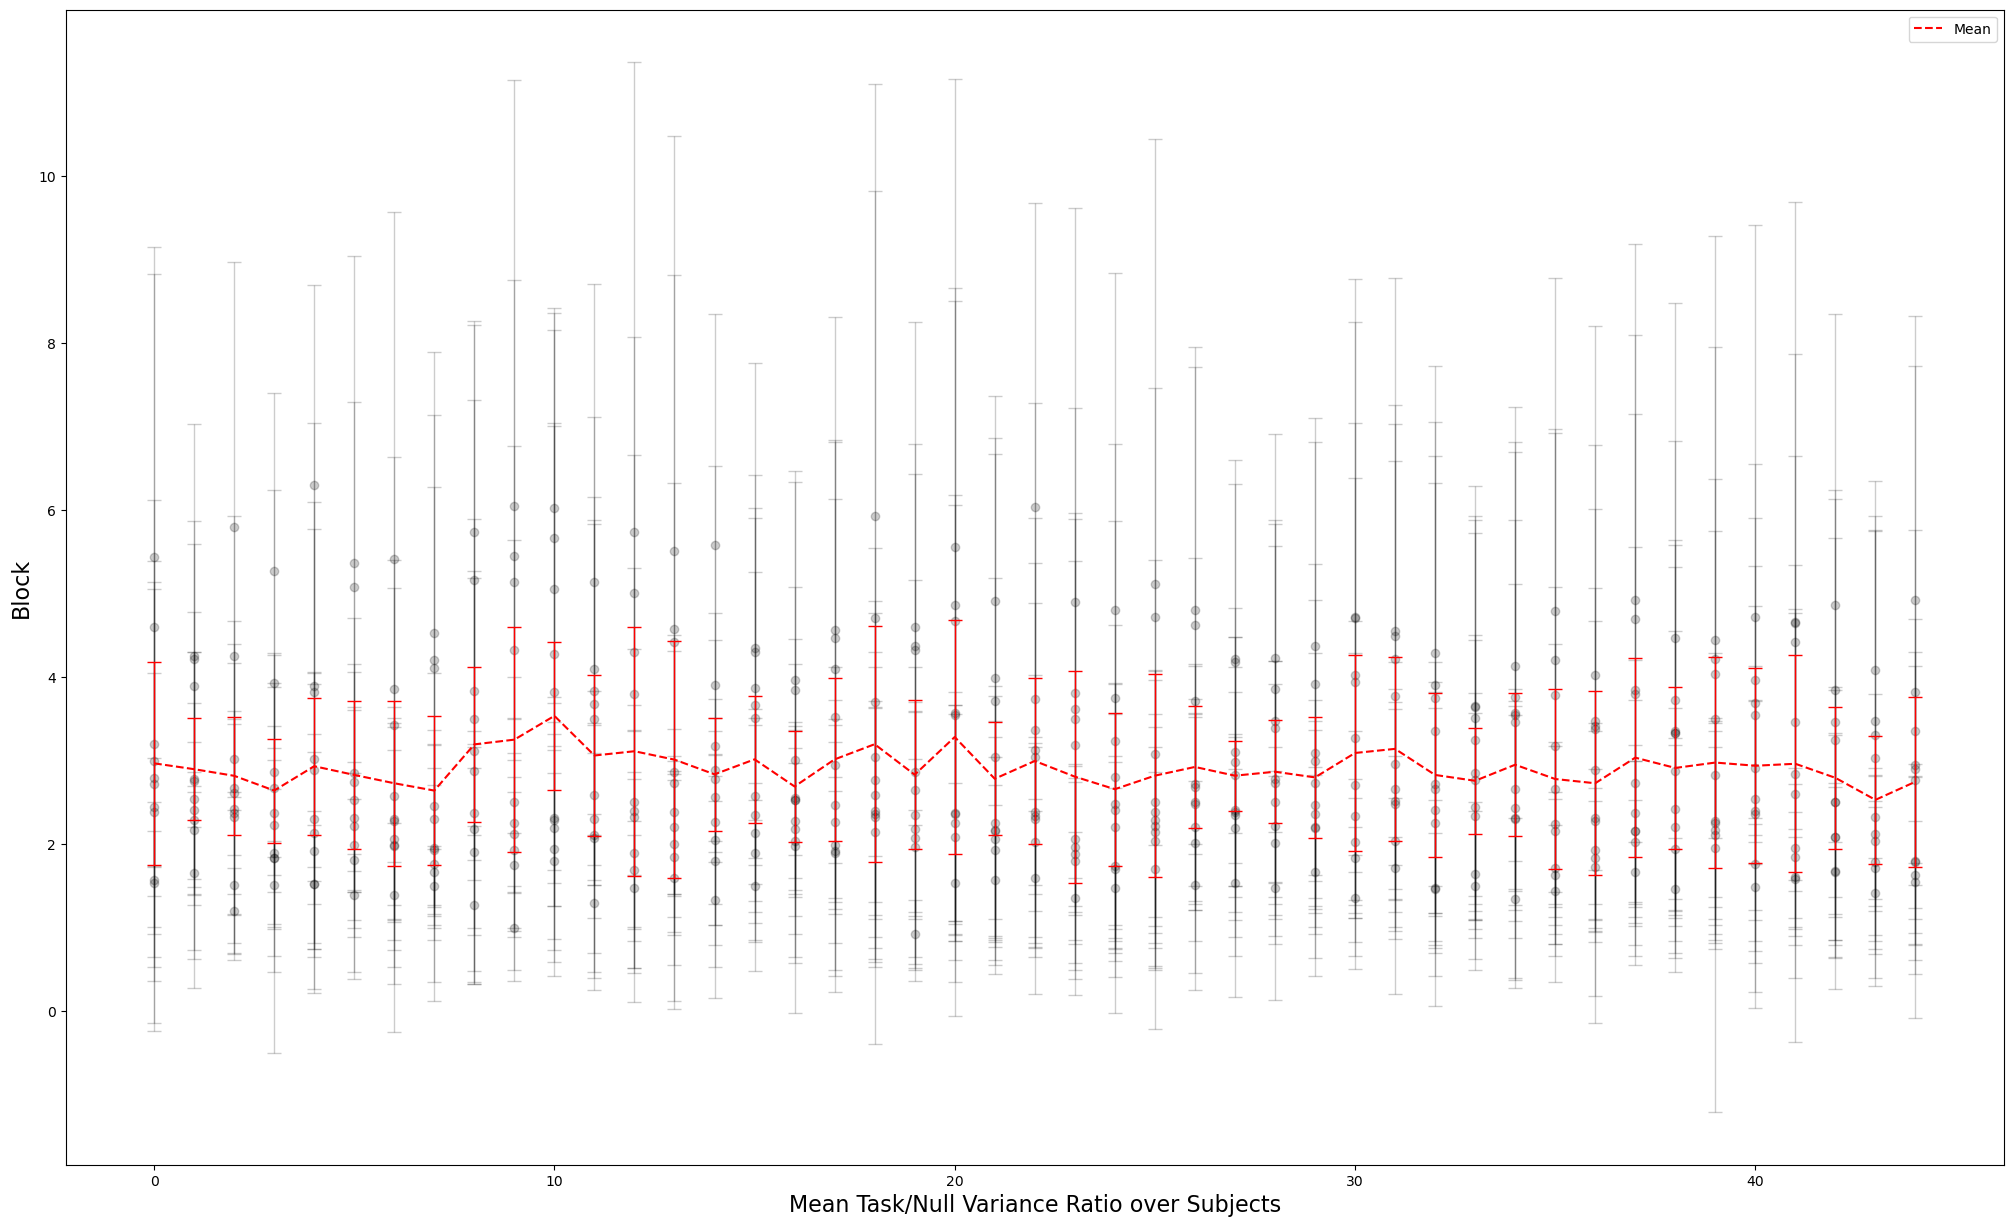

In [22]:
fig, ax = plt.subplots(figsize=(25,15))
subject_sesh_means = []
subject_sesh_stds = []
for s in c.alphabetically_sorted_subjects()[:10]:
    task_sesh_lists = task_sesh_means_over_subjects[s.name]
    null_sesh_lists = null_sesh_means_over_subjects[s.name]
    sesh_mean_ratios = []
    sesh_std_ratios = []
    for task_sesh_list, null_sesh_list in zip(task_sesh_lists, null_sesh_lists):
        ratios = np.divide(task_sesh_list, null_sesh_list)
        sesh_mean_ratios.append(np.mean(ratios))
        sesh_std_ratios.append(np.std(ratios))
    subject_sesh_means.append(sesh_mean_ratios)
    subject_sesh_stds.append(sesh_std_ratios)
    ax.plot(sesh_mean_ratios, "ko", alpha=0.2)
    ax.errorbar(range(len(sesh_mean_ratios)), sesh_mean_ratios, yerr=sesh_std_ratios, capsize=5, elinewidth=1, linewidth=0, color="k", alpha=0.2)

grand_mean = []
grand_std = []
# for each session
for i in range(45):
    # over subjects
    grand_mean.append(np.mean([x[i] for x in subject_sesh_means]))
    grand_std.append(np.std([x[i] for x in subject_sesh_stds]))
ax.plot(grand_mean, "r--", label="Mean")
ax.errorbar(range(len(grand_mean)), grand_mean, yerr=grand_std, capsize=5, elinewidth=1, linewidth=0, color="r")
ax.set_xlabel("Block")
ax.set_ylabel("Mean Task/Null Variance Ratio over Subjects")
ax.legend()

In [23]:
fig.savefig(image_path / "analysis/ratio_over_blocks.pdf", dpi=300, format="pdf")

## "Hit" variance ratio mean vs "Miss" variance ratio mean

In [29]:
len(c.alphabetically_sorted_subjects())

46

In [24]:
# for each trial
c = collection.Collection("emg_olympics")
hit_null_trial_means_over_subjects = {}
hit_task_trial_means_over_subjects = {}
hit_ratios_over_trials_over_subjects = {}
miss_null_trial_means_over_subjects = {}
miss_task_trial_means_over_subjects = {}
miss_ratios_over_trials_over_subjects = {}
for s in c.subjects.values():
    decoder = s.decoder[-2:, :]
    hit_null_trial_means_over_subjects[s.name] = []
    hit_task_trial_means_over_subjects[s.name] = []
    miss_null_trial_means_over_subjects[s.name] = []
    miss_task_trial_means_over_subjects[s.name] = []
    for sesh in s.tasks[task_name].sorted_sessions():
        for trial in sesh.sorted_trials():
            if trial.outcome == "No Hold":
                pass
            # get trajectory and cut off the hold period
            trajectory = trial.get_filtered_emg()[int(trial.hold_time*SAMPLE_RATE):,:]
            # compute the electrode covariance of the filtered emg for this trial
            covariance = compute_emg_covariance(trajectory)

            # compute task and null space basis using svd
            task_space, null_space = compute_subspaces(decoder)

            # compute mean of null space projections, add to list
            trial_null_mean = mean_quadratic_form(covariance, null_space)

            # same for the task space
            trial_task_mean = mean_quadratic_form(covariance, task_space)

            if trial.outcome == "Hit":
                hit_null_trial_means_over_subjects[s.name].append(trial_null_mean)
                hit_task_trial_means_over_subjects[s.name].append(trial_task_mean)
            elif trial.outcome == "Miss":
                miss_null_trial_means_over_subjects[s.name].append(trial_null_mean)
                miss_task_trial_means_over_subjects[s.name].append(trial_task_mean)
    hit_ratios_over_trials_over_subjects[s.name] = np.divide(hit_task_trial_means_over_subjects[s.name], hit_null_trial_means_over_subjects[s.name])
    miss_ratios_over_trials_over_subjects[s.name] = np.divide(miss_task_trial_means_over_subjects[s.name], miss_null_trial_means_over_subjects[s.name])

/var/folders/dz/870p8tdx43j5527kzthy65zw0000gn/T/ipykernel_35011/2409685215.py:28: RuntimeWarning: Degrees of freedom <= 0 for slice
  return np.cov(signal.T)
/opt/homebrew/Caskroom/miniconda/base/envs/data/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/homebrew/Caskroom/miniconda/base/envs/data/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/opt/homebrew/Caskroom/miniconda/base/envs/data/lib/python3.11/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/opt/homebrew/Caskroom/miniconda/base/envs/data/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


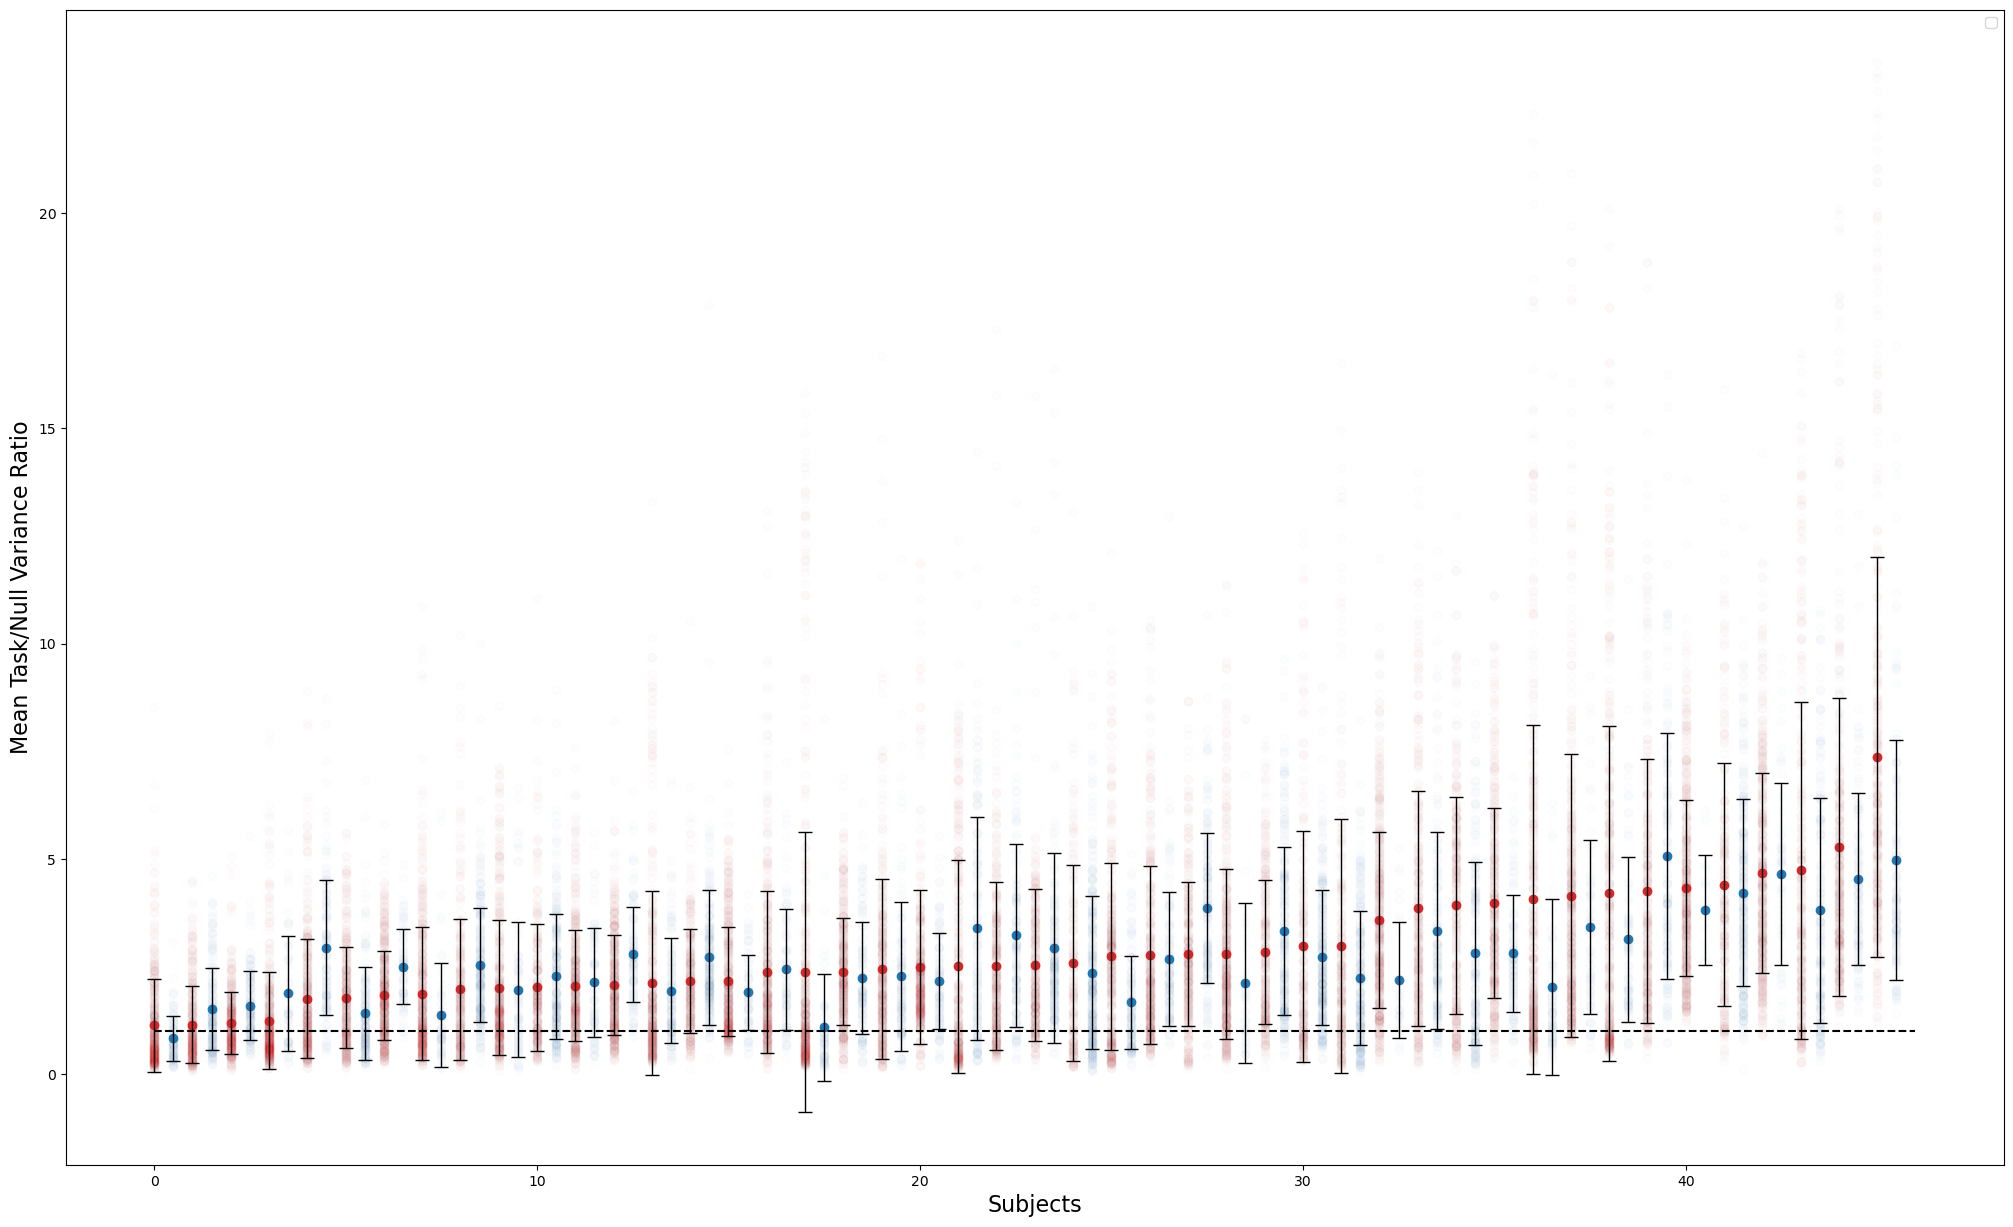

In [56]:
fig, ax = plt.subplots(figsize=(25,15))

# get subjects in order of their mean variance ratios
subject_hit_ordering = np.argsort([np.mean(hit_ratios_over_trials_over_subjects[s.name]) for s in c.alphabetically_sorted_subjects()])

for i, k in enumerate(subject_hit_ordering):
    s = c.alphabetically_sorted_subjects()[k]
    ax.plot(np.ones(hit_ratios_over_trials_over_subjects[s.name].shape)*i, hit_ratios_over_trials_over_subjects[s.name], "o", c="tab:red", alpha=0.01, label="Hit")
    ax.plot(i, np.mean(hit_ratios_over_trials_over_subjects[s.name]), "o", c="tab:red")    
    ax.errorbar(i, np.mean(hit_ratios_over_trials_over_subjects[s.name]), yerr=np.std(hit_ratios_over_trials_over_subjects[s.name]), capsize=5, elinewidth=1, linewidth=0, color="k")
    ax.plot(np.ones(miss_ratios_over_trials_over_subjects[s.name].shape)*i + 0.5, miss_ratios_over_trials_over_subjects[s.name], "o", c="tab:blue", alpha=0.01, label="Miss")
    ax.plot(i + 0.5, np.mean(miss_ratios_over_trials_over_subjects[s.name]), "o", c="tab:blue")
    ax.errorbar(i + 0.5, np.mean(miss_ratios_over_trials_over_subjects[s.name]), yerr=np.std(miss_ratios_over_trials_over_subjects[s.name]), capsize=5, elinewidth=1, linewidth=0, color="k")
ax.plot([0, subject_hit_ordering.shape[0]],[1,1],"k--")
ax.set_xlabel("Subjects")
ax.set_ylabel("Mean Task/Null Variance Ratio")
h, l = ax.get_legend_handles_labels()
ax.legend(h[-2:], l[-2:])

In [26]:
fig.savefig(image_path / "analysis/ratio_over_subjects.pdf", dpi=300, format="pdf")

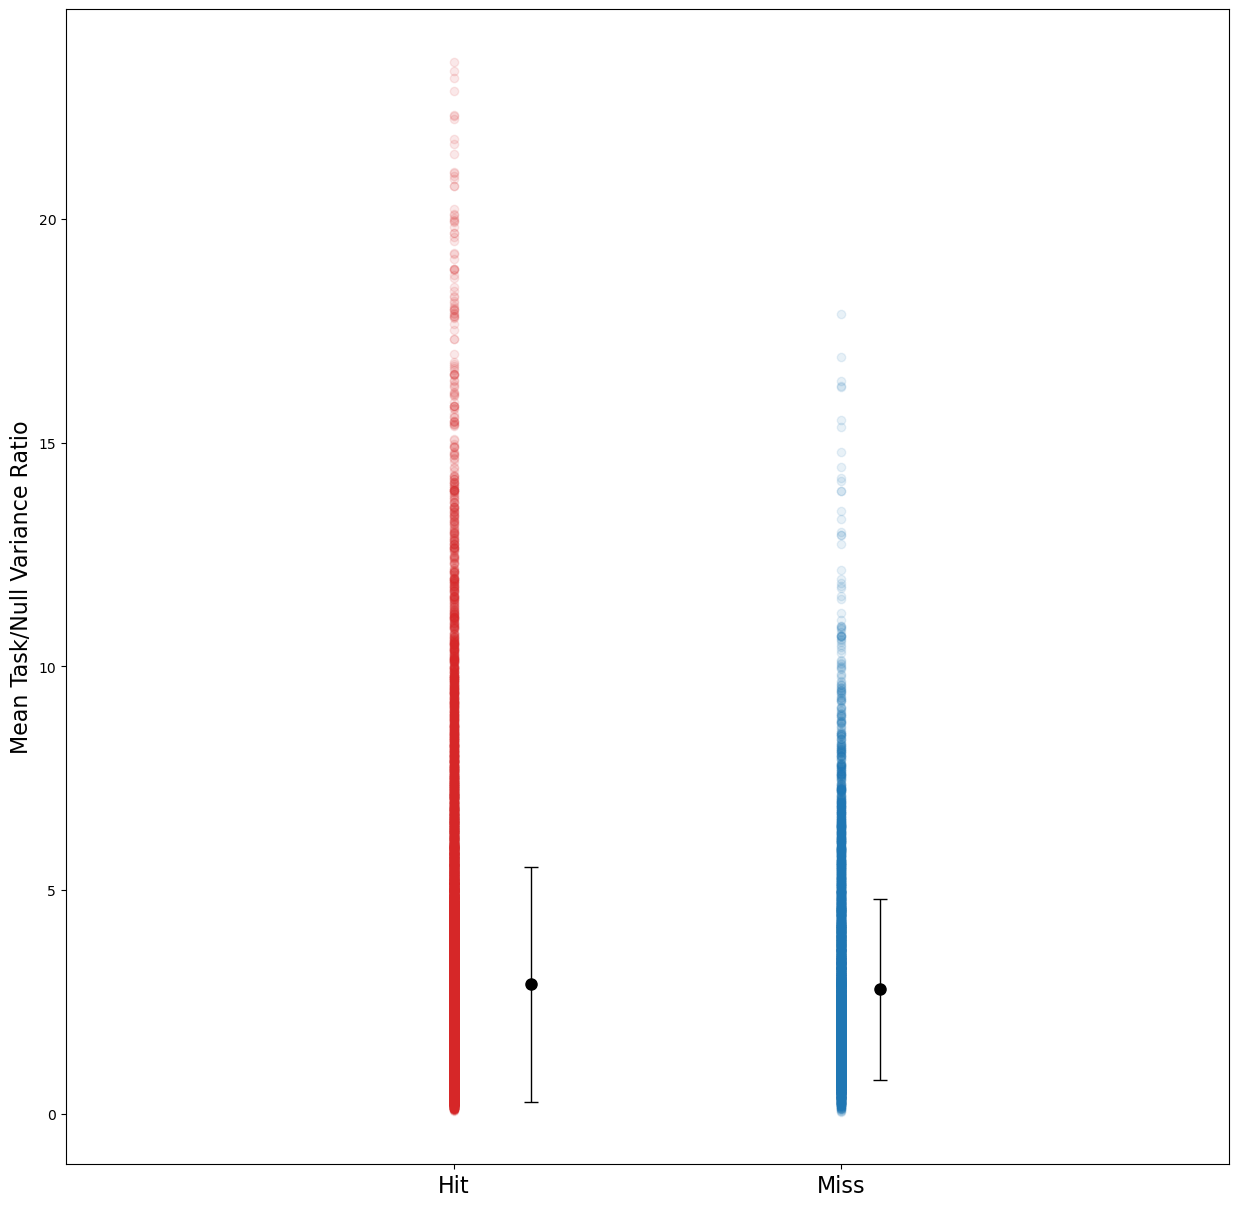

In [59]:
fig, ax = plt.subplots(figsize=(15,15))

all_hit_means = np.array([])
all_miss_means = np.array([])
for i, s in enumerate(c.alphabetically_sorted_subjects()):
    all_hit_means = np.append(all_hit_means, hit_ratios_over_trials_over_subjects[s.name])
    all_miss_means = np.append(all_miss_means, miss_ratios_over_trials_over_subjects[s.name])

ax.plot(np.zeros(len(all_hit_means)), all_hit_means, "o", c="tab:red", alpha=0.1)
ax.errorbar(0.2, np.mean(all_hit_means), yerr=np.std(all_hit_means), capsize=5, elinewidth=1, linewidth=0, color="k")
ax.plot(0.2, np.mean(all_hit_means), "ko", markersize=8)

ax.plot(np.ones(len(all_miss_means)), all_miss_means, "o", c="tab:blue", alpha=0.1)
ax.errorbar(1.1, np.mean(all_miss_means), yerr=np.std(all_miss_means), capsize=5, elinewidth=1, linewidth=0, color="k")
ax.plot(1.1, np.mean(all_miss_means), "ko", markersize=8)

ax.set_ylabel("Mean Task/Null Variance Ratio")
ax.set_xlim([-1,2])
ax.set_xticks([0,1],labels=["Hit", "Miss"], fontsize=16)

In [28]:
fig.savefig(image_path / "analysis/ratio_hit_vs_miss.pdf", dpi=300, format="pdf")

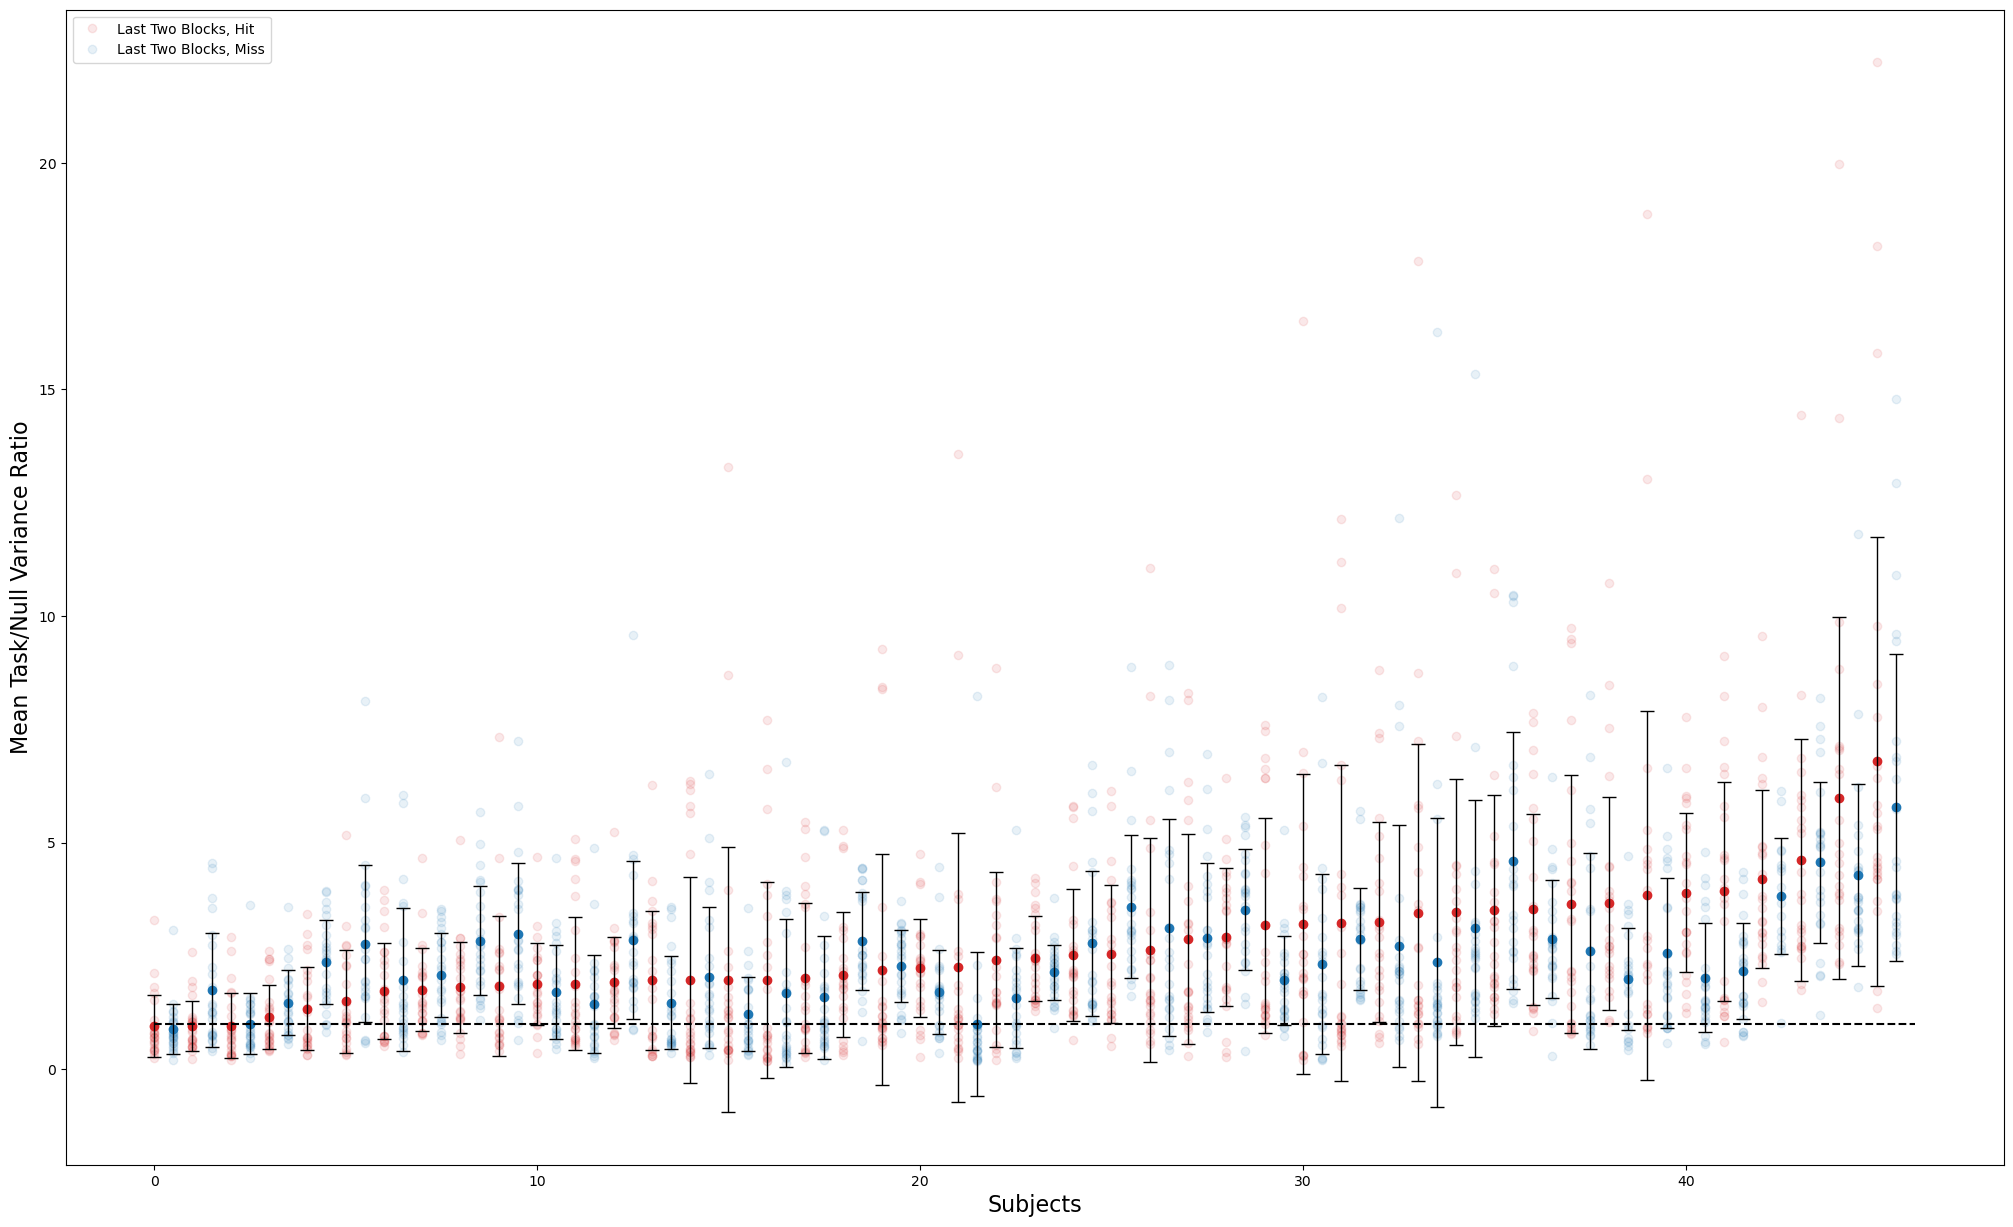

In [57]:
fig, ax = plt.subplots(figsize=(25,15))

# get subjects in order of their mean variance ratios
subject_hit_ordering = np.argsort([np.mean(hit_ratios_over_trials_over_subjects[s.name][-24:]) for s in c.alphabetically_sorted_subjects()])

for i, k in enumerate(subject_hit_ordering):
    s = c.alphabetically_sorted_subjects()[k]
    ax.plot(np.ones(hit_ratios_over_trials_over_subjects[s.name][-24:].shape)*i, hit_ratios_over_trials_over_subjects[s.name][-24:], "o", c="tab:red", alpha=0.1, label="Last Two Blocks, Hit")
    ax.plot(i, np.mean(hit_ratios_over_trials_over_subjects[s.name][-24:]), "o", c="tab:red")    
    ax.errorbar(i, np.mean(hit_ratios_over_trials_over_subjects[s.name][-24:]), yerr=np.std(hit_ratios_over_trials_over_subjects[s.name][-24:]), capsize=5, elinewidth=1, linewidth=0, color="k")
    ax.plot(np.ones(miss_ratios_over_trials_over_subjects[s.name][-24:].shape)*i + 0.5, miss_ratios_over_trials_over_subjects[s.name][-24:], "o", c="tab:blue", alpha=0.1, label="Last Two Blocks, Miss")
    ax.plot(i + 0.5, np.mean(miss_ratios_over_trials_over_subjects[s.name][-24:]), "o", c="tab:blue")
    ax.errorbar(i + 0.5, np.mean(miss_ratios_over_trials_over_subjects[s.name][-24:]), yerr=np.std(miss_ratios_over_trials_over_subjects[s.name][-24:]), capsize=5, elinewidth=1, linewidth=0, color="k")
ax.plot([0, subject_hit_ordering.shape[0]],[1,1],"k--")
ax.set_xlabel("Subjects")
ax.set_ylabel("Mean Task/Null Variance Ratio")
h, l = ax.get_legend_handles_labels()
ax.legend(h[-2:], l[-2:])

In [ ]:
fig.savefig(image_path / "analysis/ratio_hit_vs_miss_last_blocks.pdf", dpi=300, format="pdf")

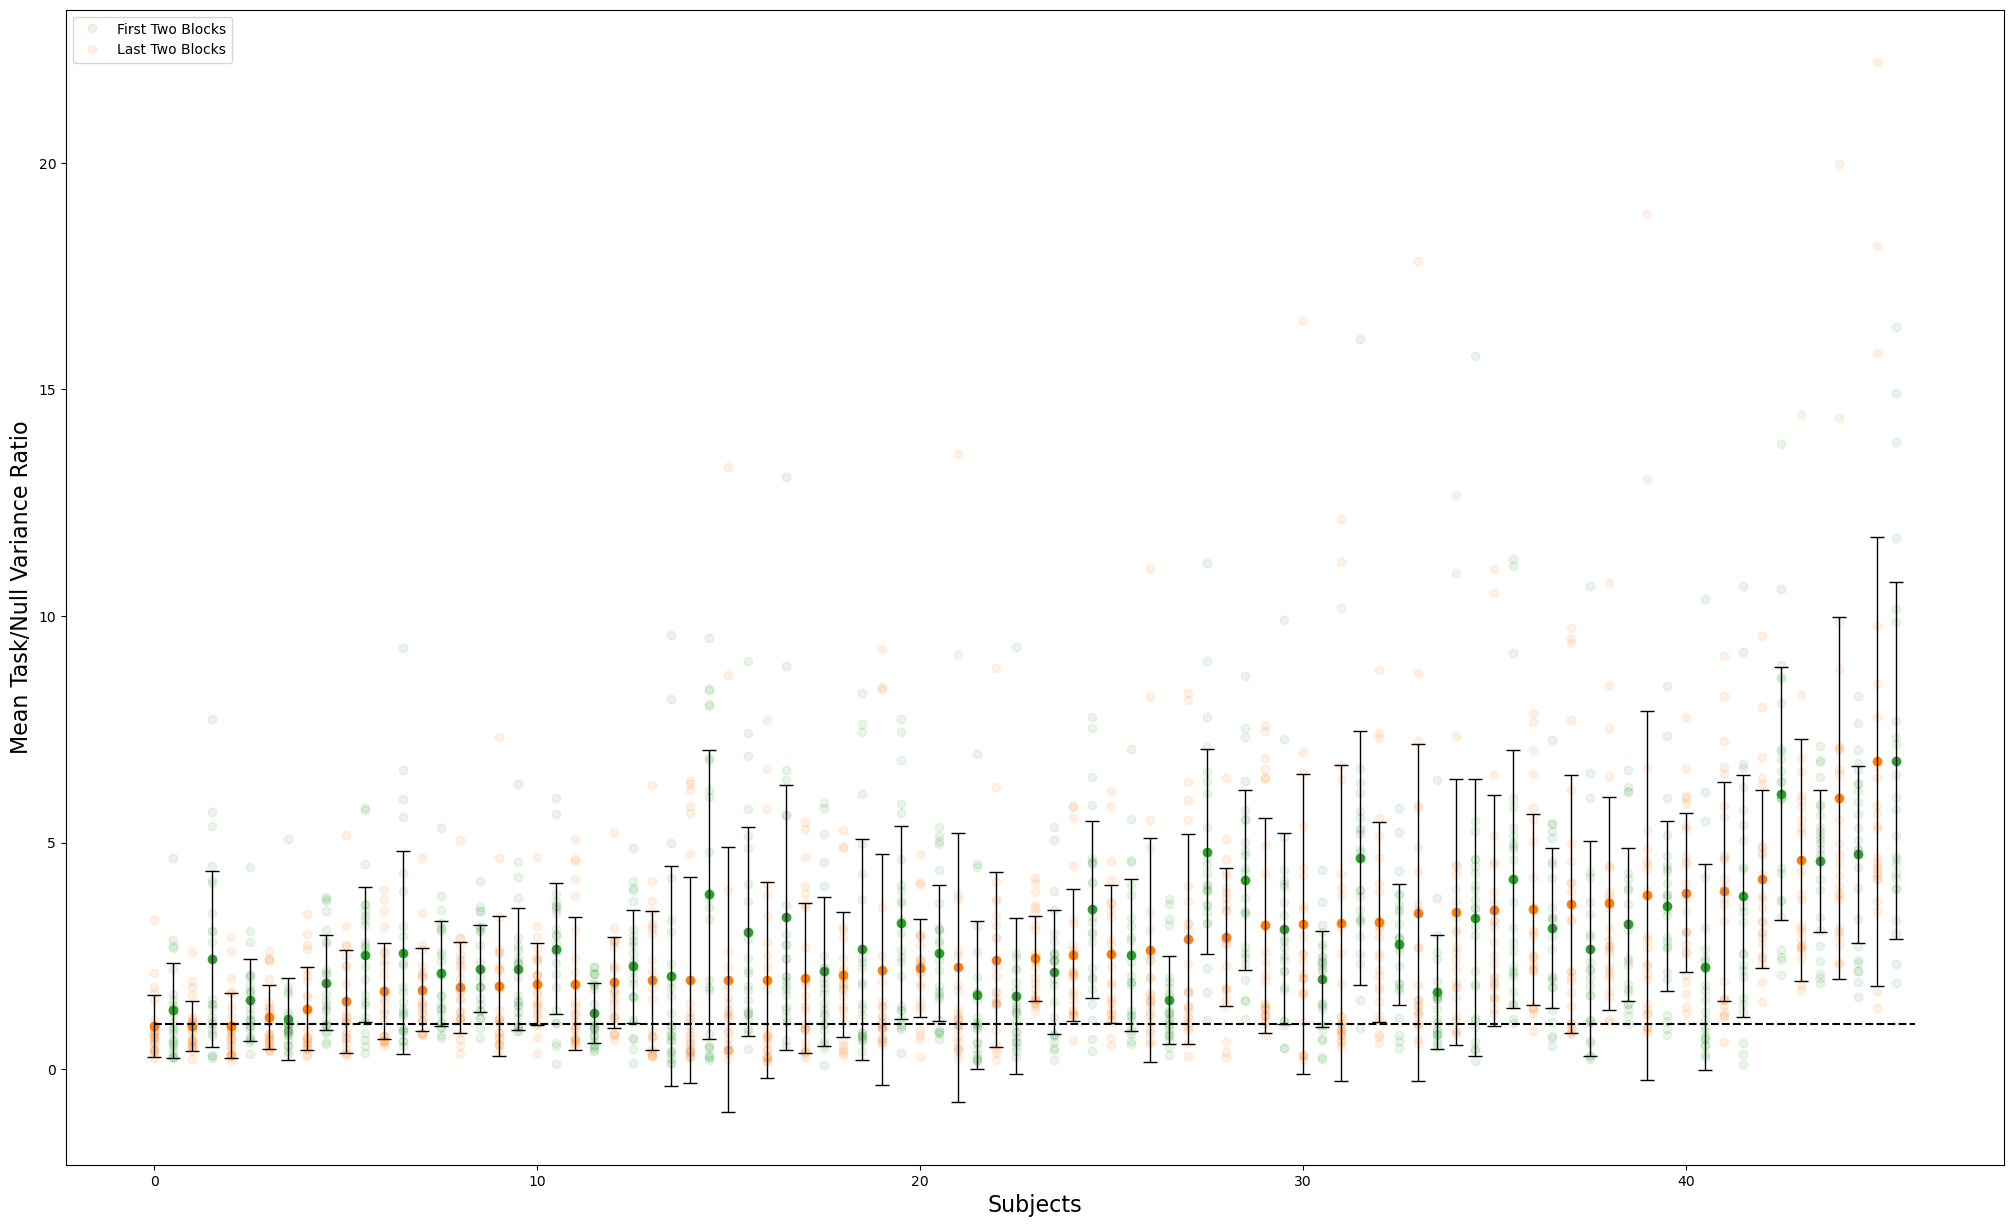

In [53]:
fig, ax = plt.subplots(figsize=(25,15))

# get subjects in order of their mean variance ratios
subject_hit_ordering = np.argsort([np.mean(hit_ratios_over_trials_over_subjects[s.name][-24:]) for s in c.alphabetically_sorted_subjects()])

for i, k in enumerate(subject_hit_ordering):
    s = c.alphabetically_sorted_subjects()[k]
    ax.plot(np.ones(hit_ratios_over_trials_over_subjects[s.name][:24].shape)*i + 0.5, hit_ratios_over_trials_over_subjects[s.name][:24], "o", c="tab:green", alpha=0.1, label="First Two Blocks")
    ax.plot(i + 0.5, np.mean(hit_ratios_over_trials_over_subjects[s.name][:24]), "o", color="tab:green")
    ax.errorbar(i + 0.5, np.mean(hit_ratios_over_trials_over_subjects[s.name][:24]), yerr=np.std(hit_ratios_over_trials_over_subjects[s.name][:24]), capsize=5, elinewidth=1, linewidth=0, color="k")

    ax.plot(np.ones(hit_ratios_over_trials_over_subjects[s.name][-24:].shape)*i, hit_ratios_over_trials_over_subjects[s.name][-24:], "o", c="tab:orange", alpha=0.1, label="Last Two Blocks")
    ax.plot(i, np.mean(hit_ratios_over_trials_over_subjects[s.name][-24:]), "o", color="tab:orange")    
    ax.errorbar(i, np.mean(hit_ratios_over_trials_over_subjects[s.name][-24:]), yerr=np.std(hit_ratios_over_trials_over_subjects[s.name][-24:]), capsize=5, elinewidth=1, linewidth=0, color="k")
ax.plot([0, subject_hit_ordering.shape[0]],[1,1],"k--")
ax.set_xlabel("Subjects")
ax.set_ylabel("Mean Task/Null Variance Ratio")
h, l = ax.get_legend_handles_labels()
ax.legend(h[-2:], l[-2:])

In [ ]:
fig.savefig(image_path / "analysis/ratio_hit_first_last_two_blocks.pdf", dpi=300, format="pdf")